In [13]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast

In [46]:
!pip uninstall -y google-generativeai google-cloud-aiplatform google-api-core google
!pip install --upgrade pip setuptools
!pip install google-generativeai

Found existing installation: google-generativeai 0.8.5


Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
Found existing installation: google-api-core 2.24.2
Uninstalling google-api-core-2.24.2:
  Successfully uninstalled google-api-core-2.24.2
  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-80.3.1-py3-none-any.whl (1.2 MB)


ERROR: To modify pip, please run the following command:
C:\Users\brian\anaconda3\python.exe -m pip install --upgrade pip setuptools


  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached google_api_core-2.24.2-py3-none-any.whl.metadata (3.0 kB)
Using cached google_generativeai-0.8.5-py3-none-any.whl (155 kB)
Using cached google_api_core-2.24.2-py3-none-any.whl (160 kB)


# Data Cleaning

In [47]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
COLOR_WORDS = {
    'red', 'green', 'blue', 'yellow', 'black', 'white', 'pink', 'orange', 'purple', 'brown',
    'grey', 'gray', 'ivory', 'beige', 'silver', 'gold', 'multi', 'navy', 'lime', 'turquoise'
}

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_description(desc):
    # Convert description to lowercase
    desc = desc.lower()

    # Remove numbers
    desc = re.sub(r'\d+', '', desc)

    # Remove punctuation/special characters
    desc = re.sub(r'[^\w\s]', '', desc)

    words = desc.split()

    # Remove color words
    words = [word for word in words if word not in COLOR_WORDS]

    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [49]:
df = pd.read_json("../dataset/online_retail.json")
descriptions = set(df['Description'])

In [50]:
cleaned_descriptions = []

for description in descriptions:
    cleaned = clean_description(description)
    cleaned_descriptions.append(cleaned)

In [51]:
description_df = pd.DataFrame({
    'Description': list(descriptions),
    "Cleaned": cleaned_descriptions
})

# Clustering

In [52]:
import google.generativeai as genai
import json

In [53]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [54]:
api_key = secrets['GEMINI_API_KEY']
genai.configure(api_key=api_key)

In [55]:
embeddings = [
    genai.embed_content(
        model="models/embedding-001",
        content=desc,
        task_type="semantic_similarity"
    )['embedding']
    for desc in description_df["Cleaned"]
]

In [56]:
description_df['Embedding'] = embeddings

In [57]:
description_df.to_csv("../dataset/descriptions.csv", index=False)


In [2]:
description_df  = pd.read_csv("../dataset/descriptions.csv")

In [14]:
description_df['Embedding'] = description_df['Embedding'].apply(ast.literal_eval)
embeddings = np.array(description_df['Embedding'].tolist())

In [3]:
df = pd.read_json("../dataset/online_retail.json")
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate units sold by product and date
daily_sales = df.groupby(['Date', 'Description'])['UnitsSold'].sum().unstack(fill_value=0)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)

In [16]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_reduced = reducer.fit_transform(embeddings)

c:\Users\brian\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# K-Means

In [61]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [63]:
# Full embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(embeddings)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(embeddings, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.0303
k=3, silhouette score=0.0563
k=4, silhouette score=0.0558
k=5, silhouette score=0.0634
k=6, silhouette score=0.0531
k=7, silhouette score=0.0775
k=8, silhouette score=0.0748
k=9, silhouette score=0.0613
k=10, silhouette score=0.0613
k=11, silhouette score=0.0864
k=12, silhouette score=0.0860
k=13, silhouette score=0.0940
k=14, silhouette score=0.0879
k=15, silhouette score=0.1023
k=16, silhouette score=0.1020
k=17, silhouette score=0.1247
k=18, silhouette score=0.0982
k=19, silhouette score=0.1292
k=20, silhouette score=0.1068
k=21, silhouette score=0.1282
k=22, silhouette score=0.0963
k=23, silhouette score=0.1215
k=24, silhouette score=0.1229
k=25, silhouette score=0.1182
k=26, silhouette score=0.1284
k=27, silhouette score=0.1402
k=28, silhouette score=0.1278
k=29, silhouette score=0.1347
k=30, silhouette score=0.1238


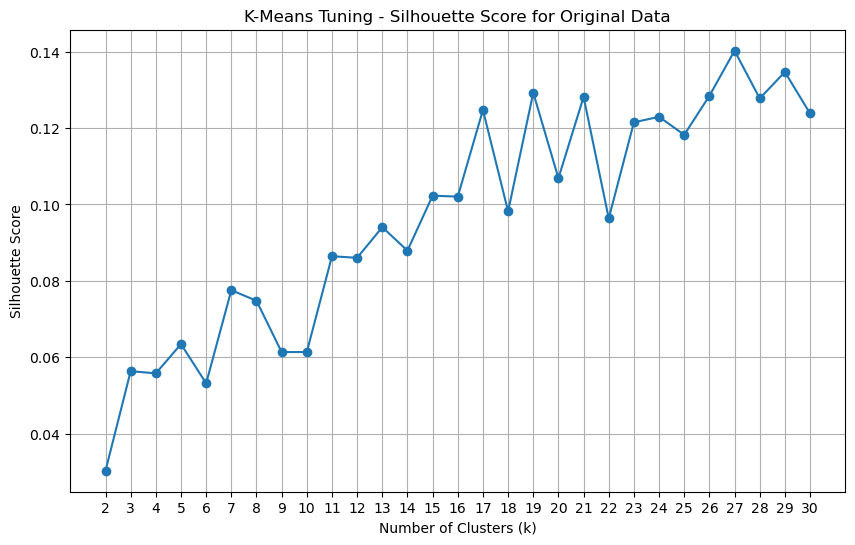

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Score for Original Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

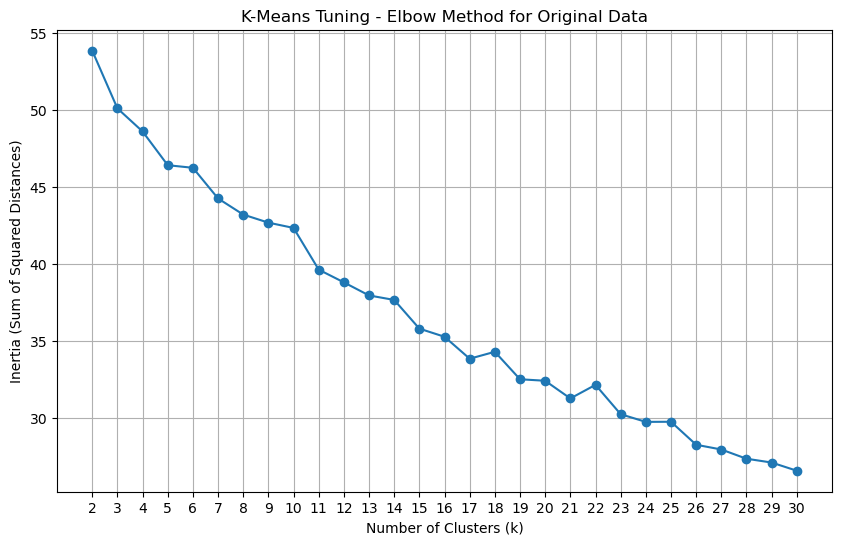

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for Original Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [66]:
# PCA Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.0829
k=3, silhouette score=0.1390
k=4, silhouette score=0.1847
k=5, silhouette score=0.1604
k=6, silhouette score=0.1920
k=7, silhouette score=0.2008
k=8, silhouette score=0.2384
k=9, silhouette score=0.2362
k=10, silhouette score=0.2467
k=11, silhouette score=0.2509
k=12, silhouette score=0.2660
k=13, silhouette score=0.2674
k=14, silhouette score=0.2608
k=15, silhouette score=0.2594
k=16, silhouette score=0.2678
k=17, silhouette score=0.2415
k=18, silhouette score=0.2220
k=19, silhouette score=0.2449
k=20, silhouette score=0.2029
k=21, silhouette score=0.2555
k=22, silhouette score=0.2654
k=23, silhouette score=0.2426
k=24, silhouette score=0.2044
k=25, silhouette score=0.2581
k=26, silhouette score=0.2356
k=27, silhouette score=0.2566
k=28, silhouette score=0.2482
k=29, silhouette score=0.2802
k=30, silhouette score=0.2688


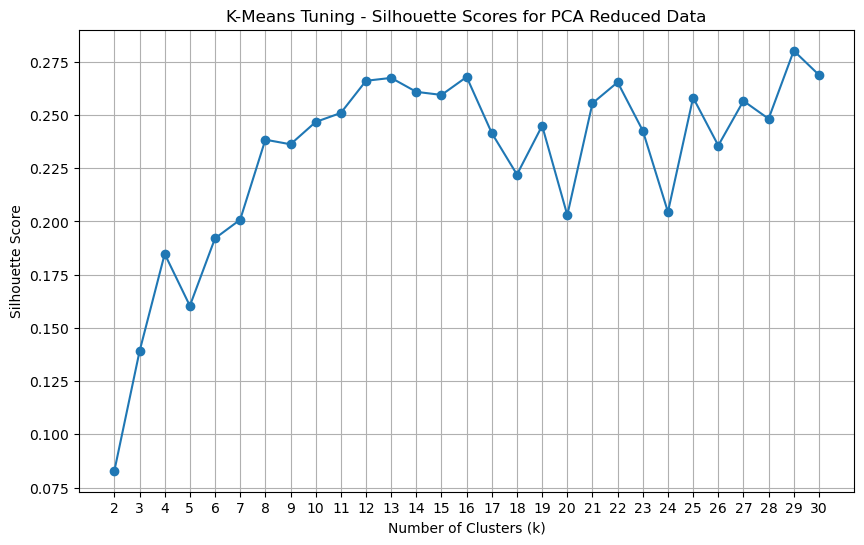

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Scores for PCA Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

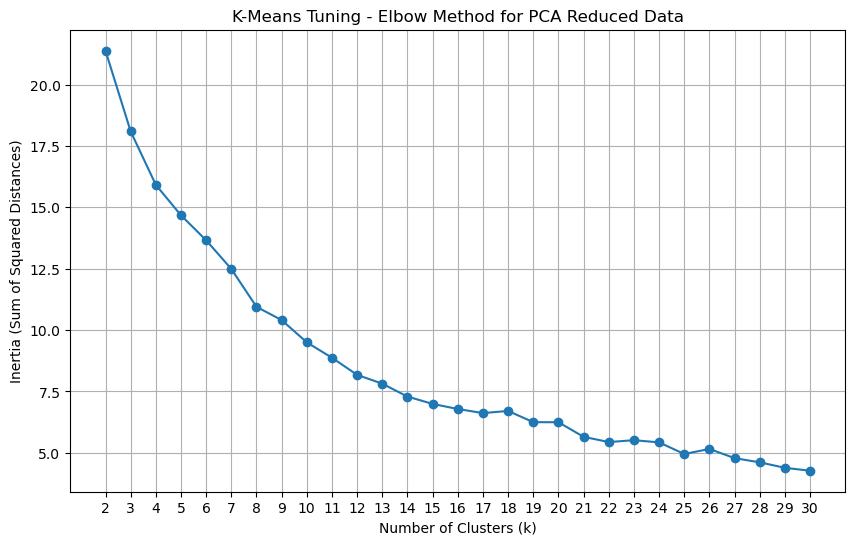

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for PCA Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [69]:
# UMAP Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(umap_reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(umap_reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.4213
k=3, silhouette score=0.3905
k=4, silhouette score=0.4420
k=5, silhouette score=0.4268
k=6, silhouette score=0.4254
k=7, silhouette score=0.4555
k=8, silhouette score=0.4954
k=9, silhouette score=0.5165
k=10, silhouette score=0.5169
k=11, silhouette score=0.5047
k=12, silhouette score=0.5157
k=13, silhouette score=0.5258
k=14, silhouette score=0.5577
k=15, silhouette score=0.5110
k=16, silhouette score=0.5148
k=17, silhouette score=0.5169
k=18, silhouette score=0.5199
k=19, silhouette score=0.5265
k=20, silhouette score=0.5406
k=21, silhouette score=0.5233
k=22, silhouette score=0.5231
k=23, silhouette score=0.5153
k=24, silhouette score=0.5279
k=25, silhouette score=0.5035
k=26, silhouette score=0.4764
k=27, silhouette score=0.5410
k=28, silhouette score=0.4949
k=29, silhouette score=0.4951
k=30, silhouette score=0.5286


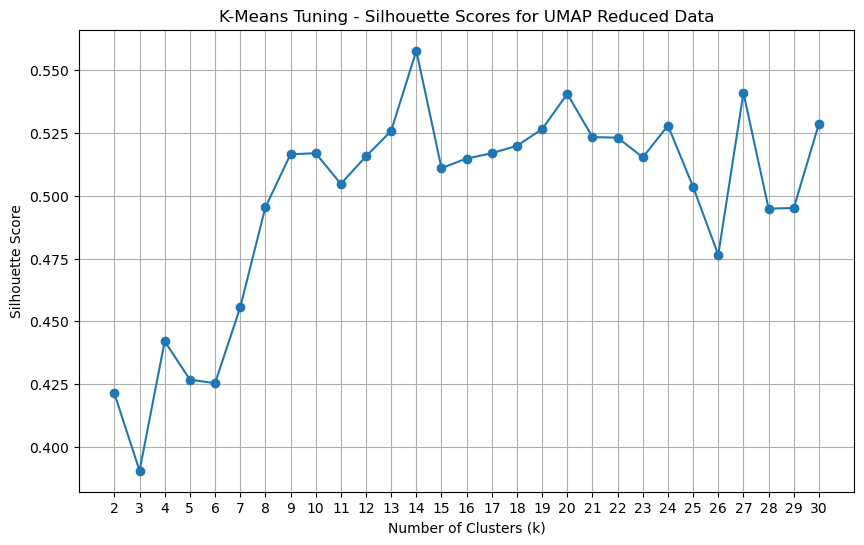

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Scores for UMAP Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

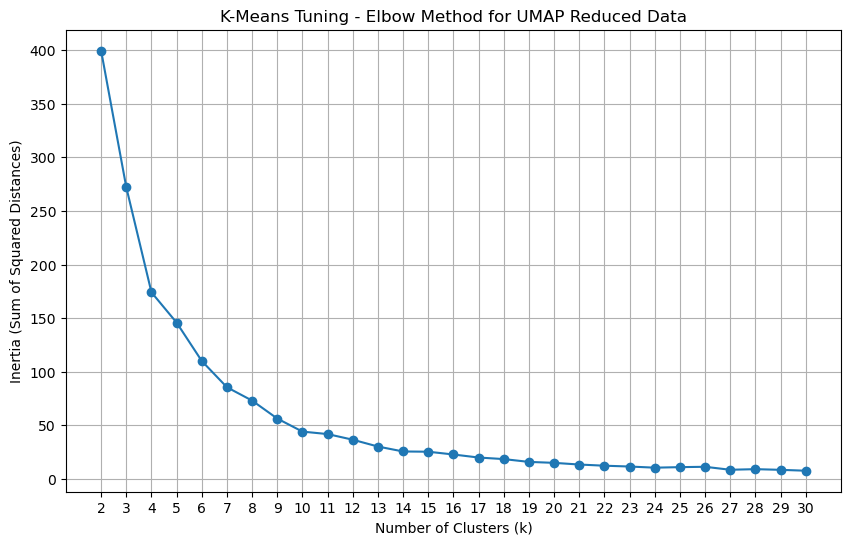

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for UMAP Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [72]:
kmeans = KMeans(n_clusters=13)
labels = kmeans.fit_predict(umap_reduced)

In [73]:
description_df['K-Means_Cluster'] = labels

In [74]:
df = df.merge(
    description_df[['Description', 'K-Means_Cluster']],
    left_on='Description',
    right_on='Description',
    how='left'
)

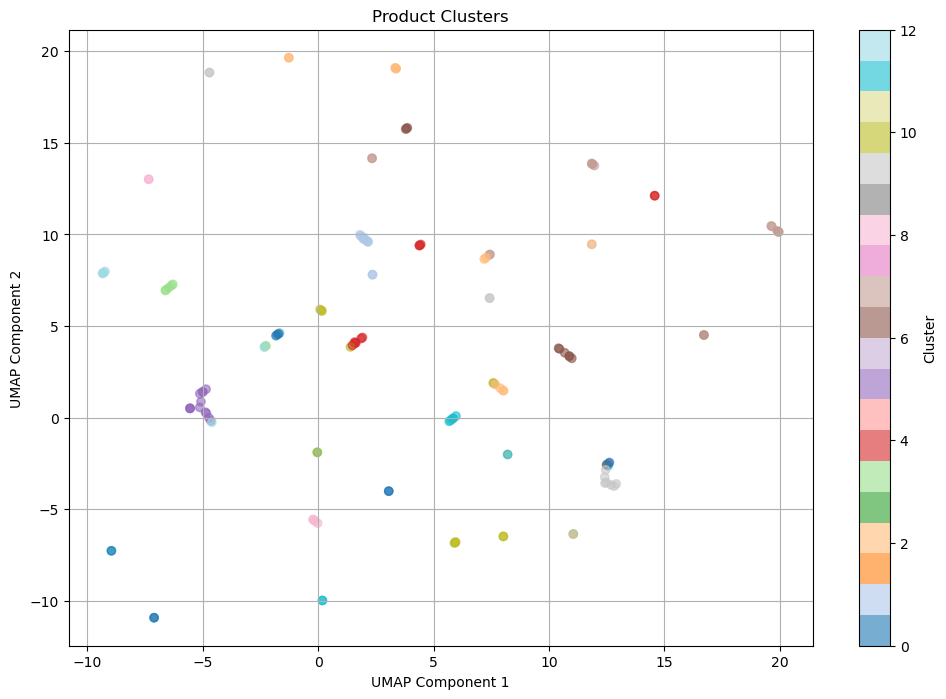

In [75]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['K-Means_Cluster'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

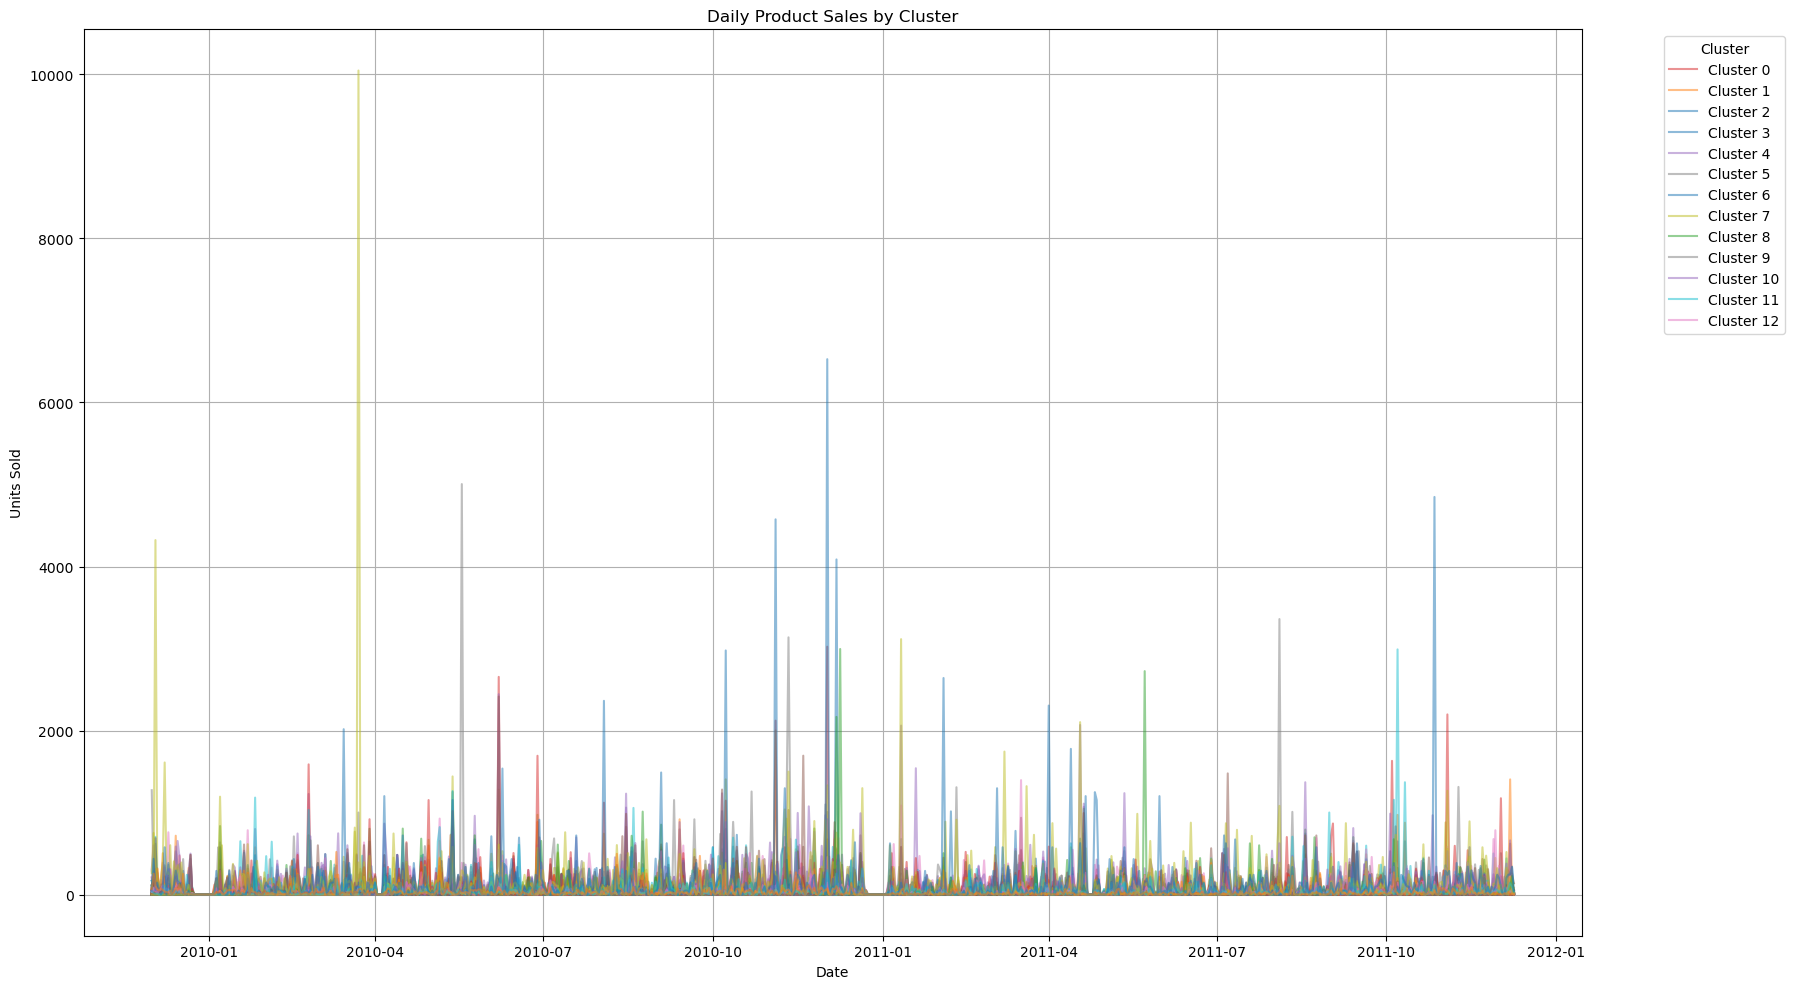

In [76]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'K-Means_Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

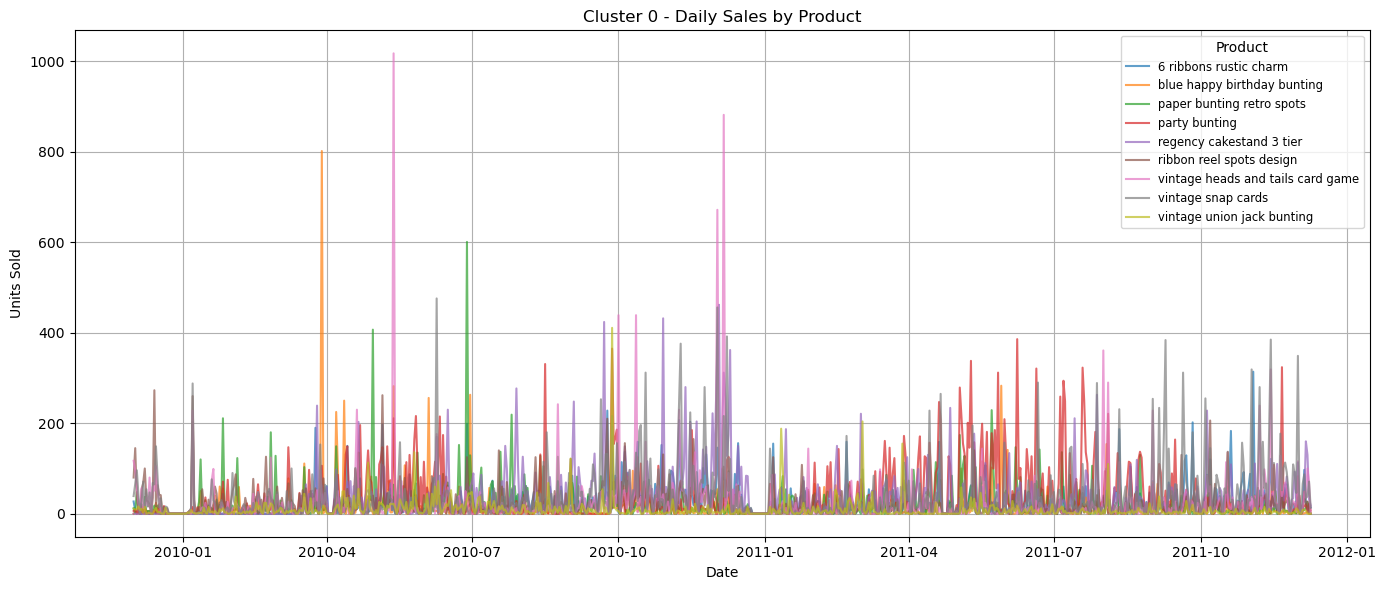

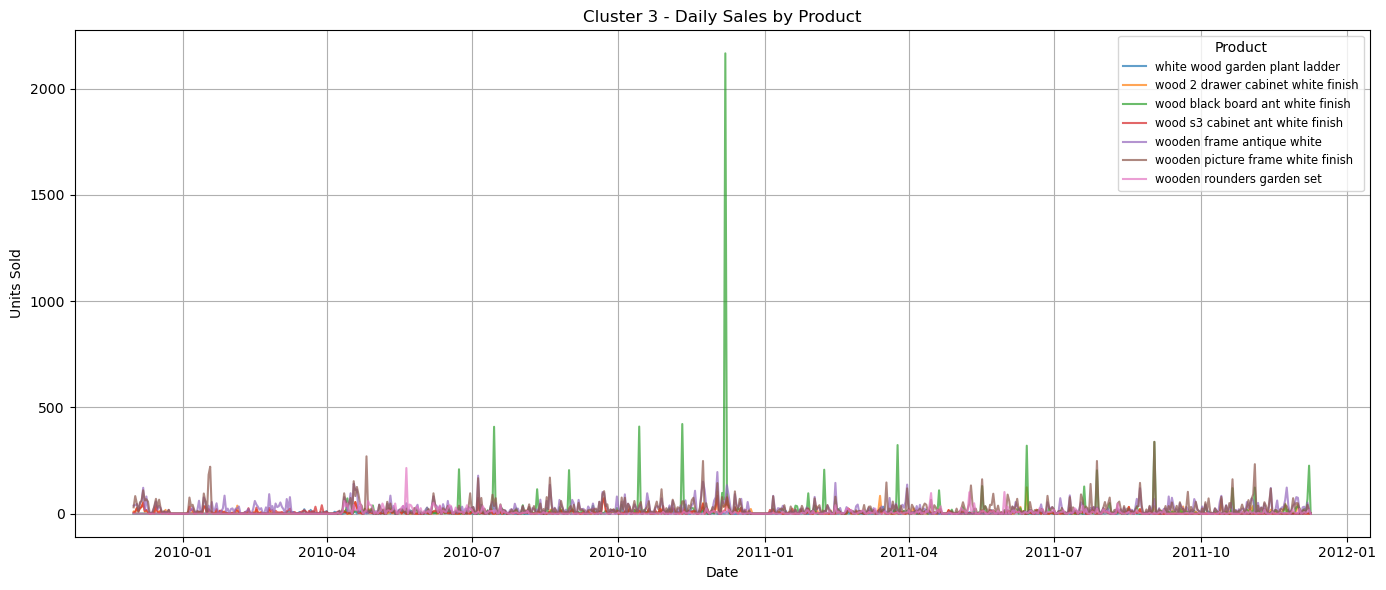

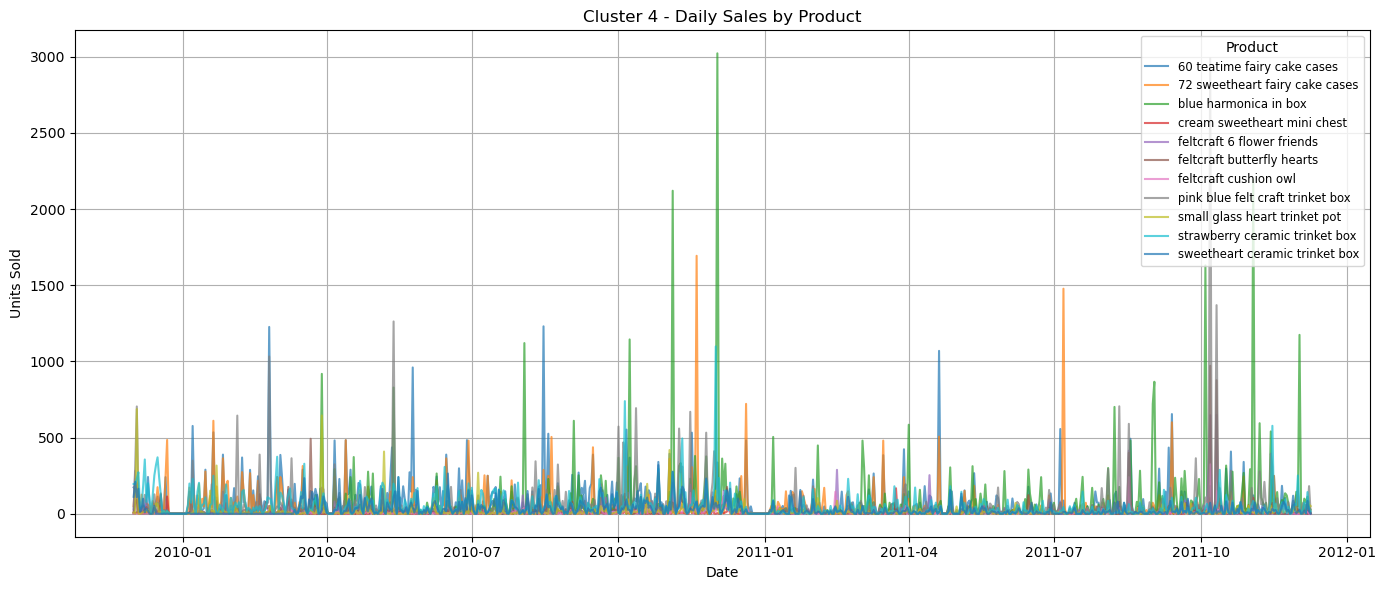

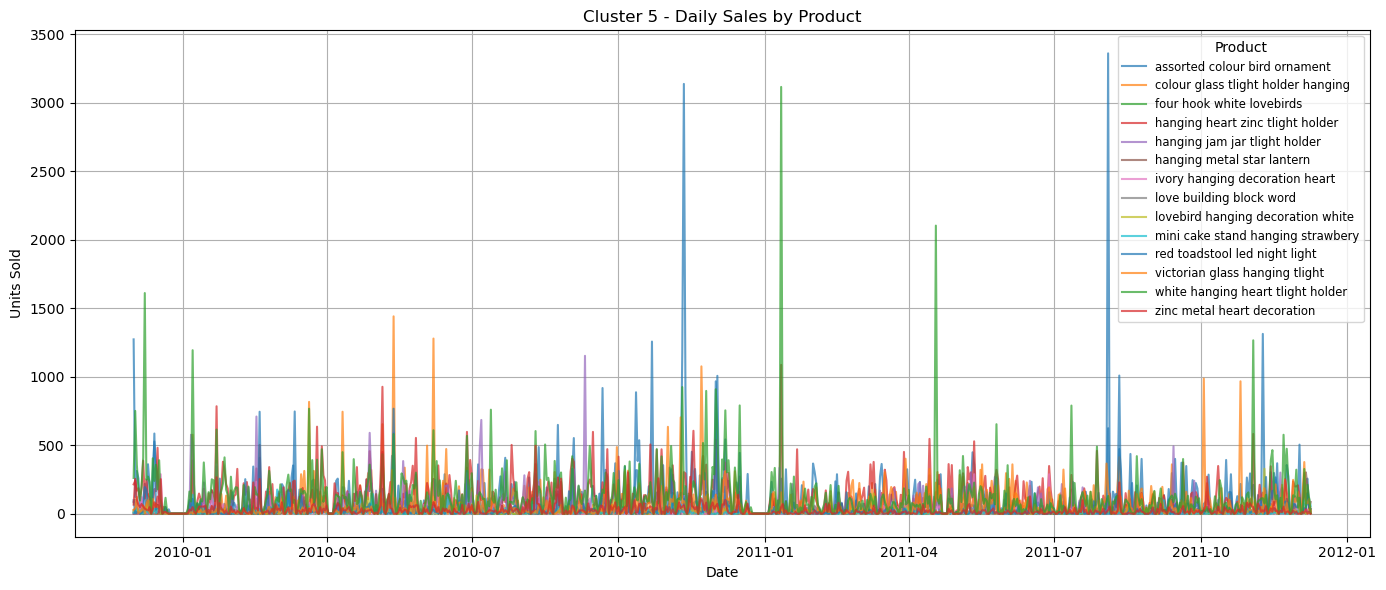

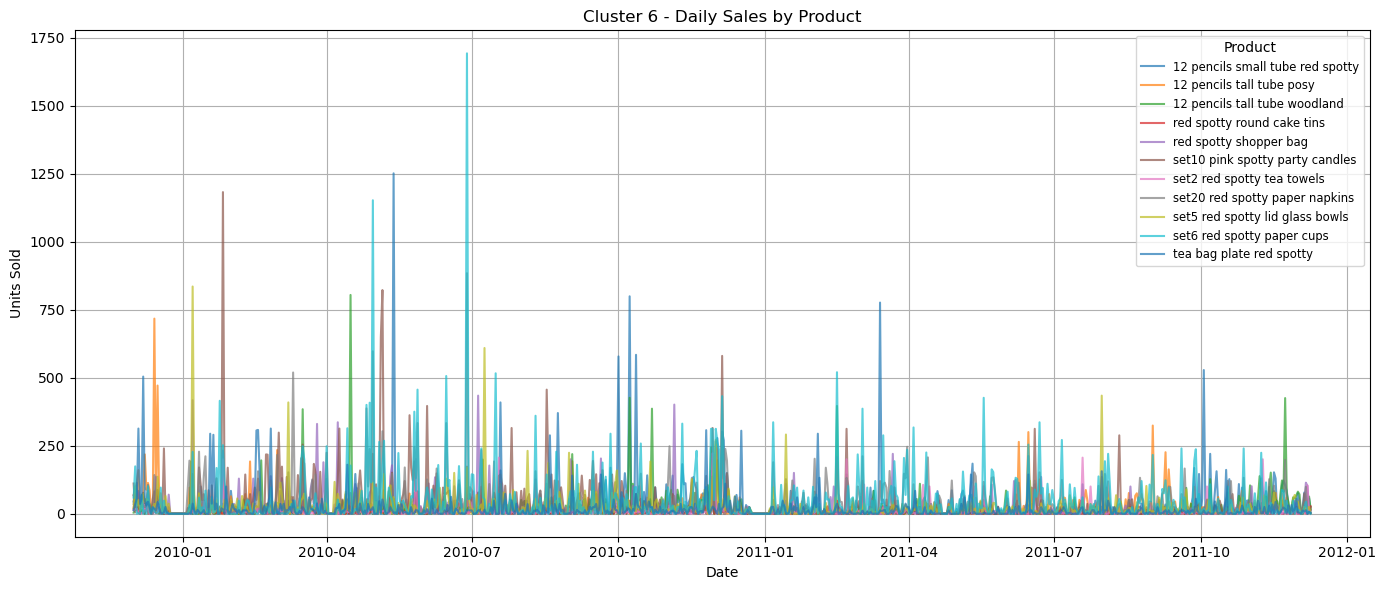

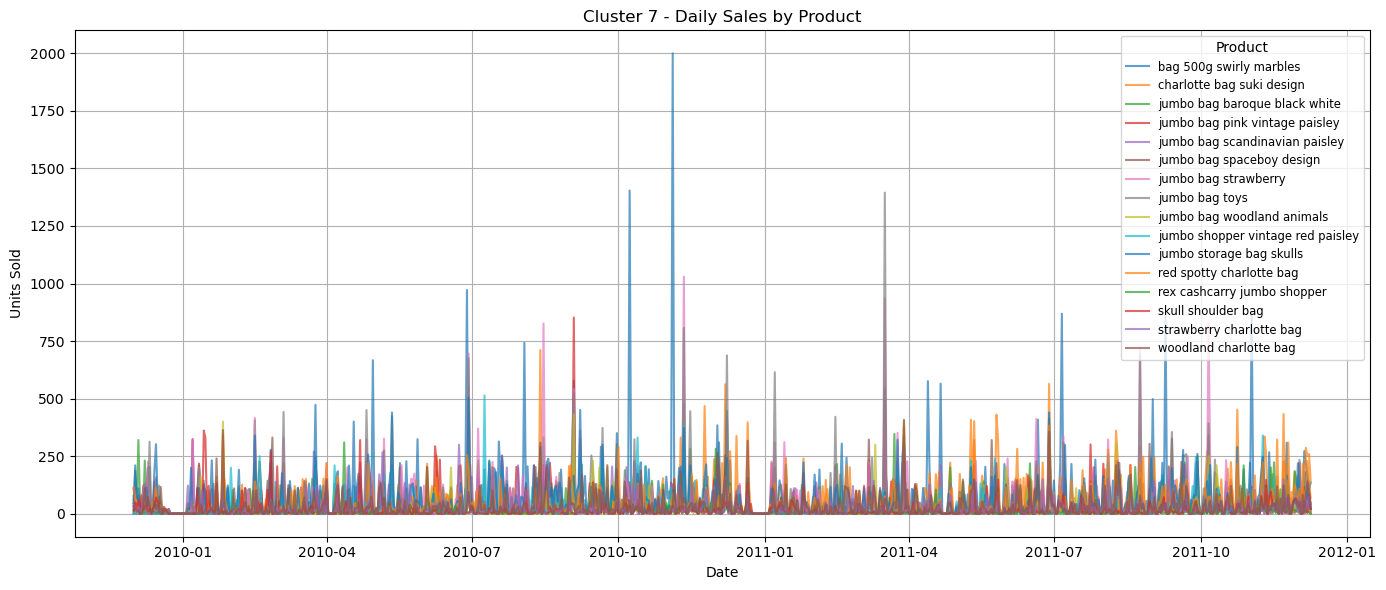

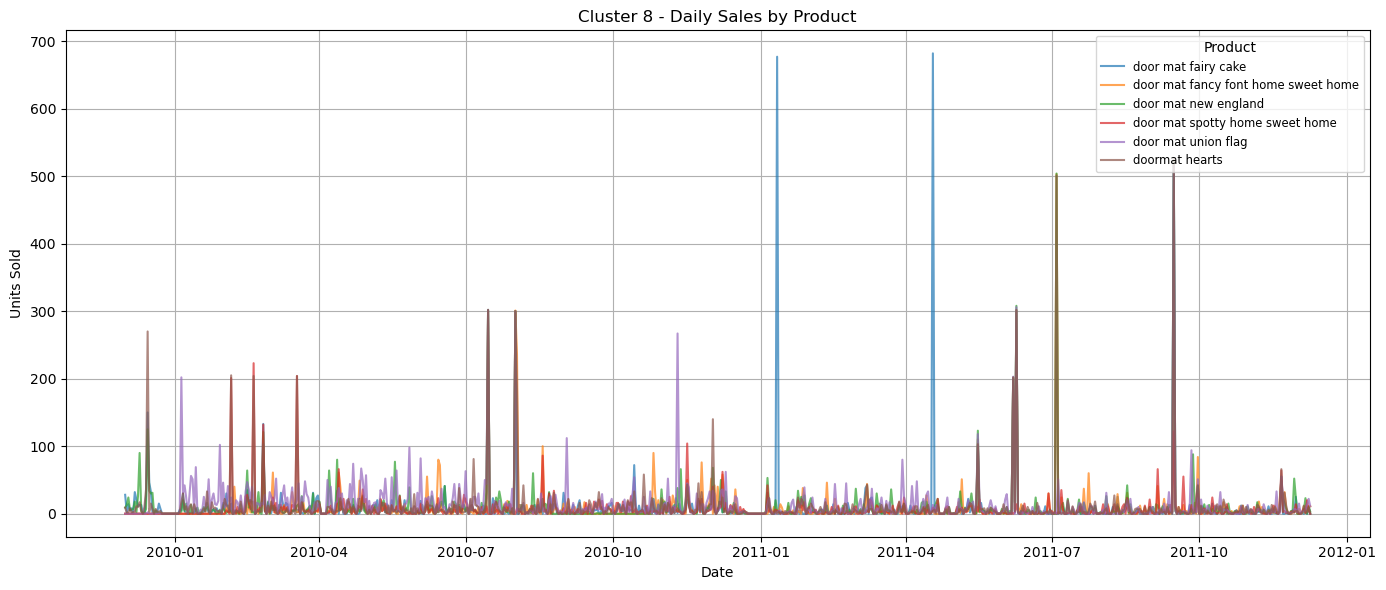

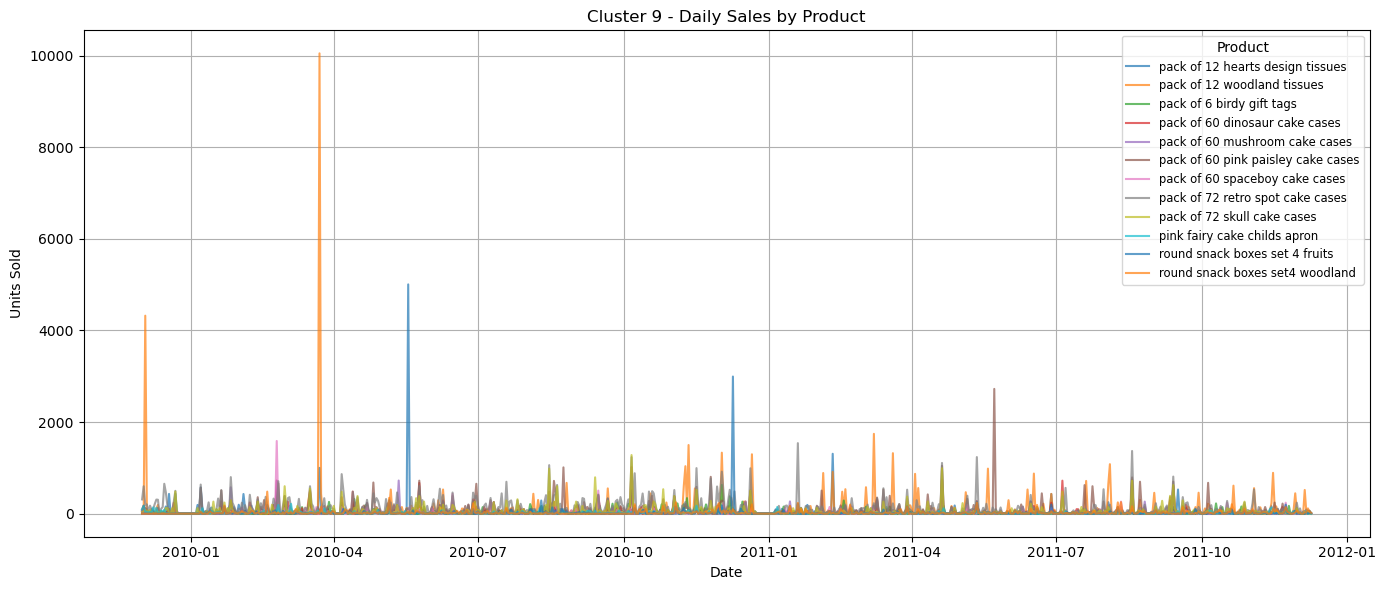

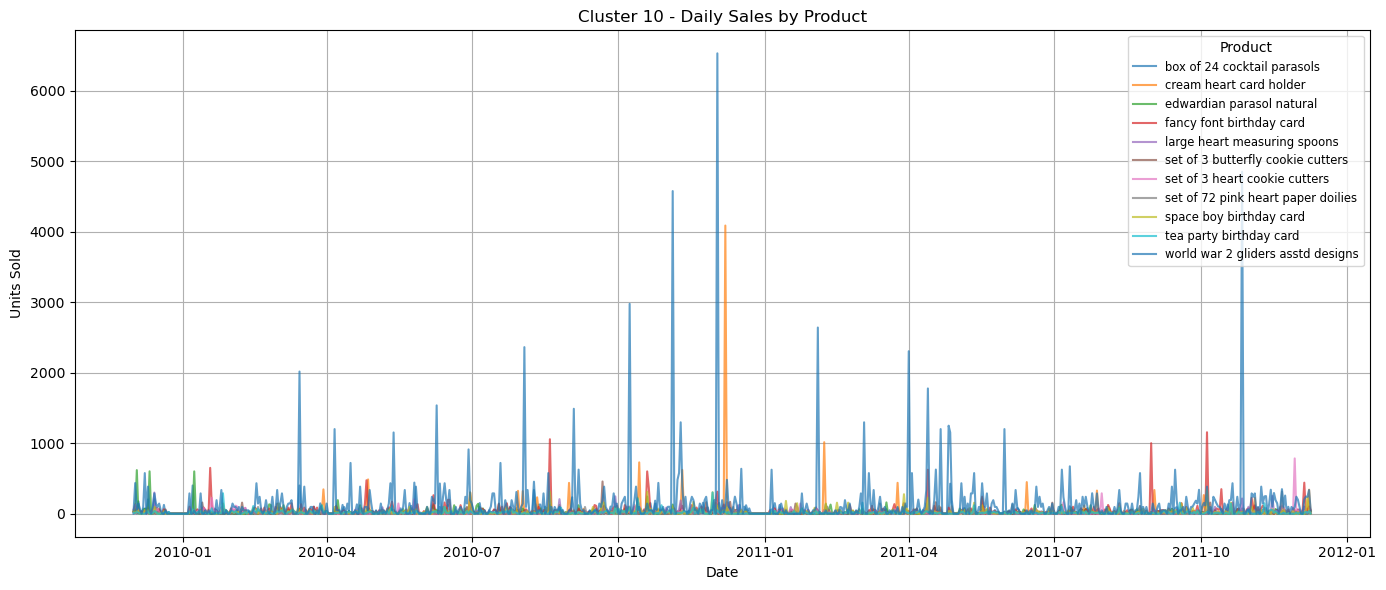

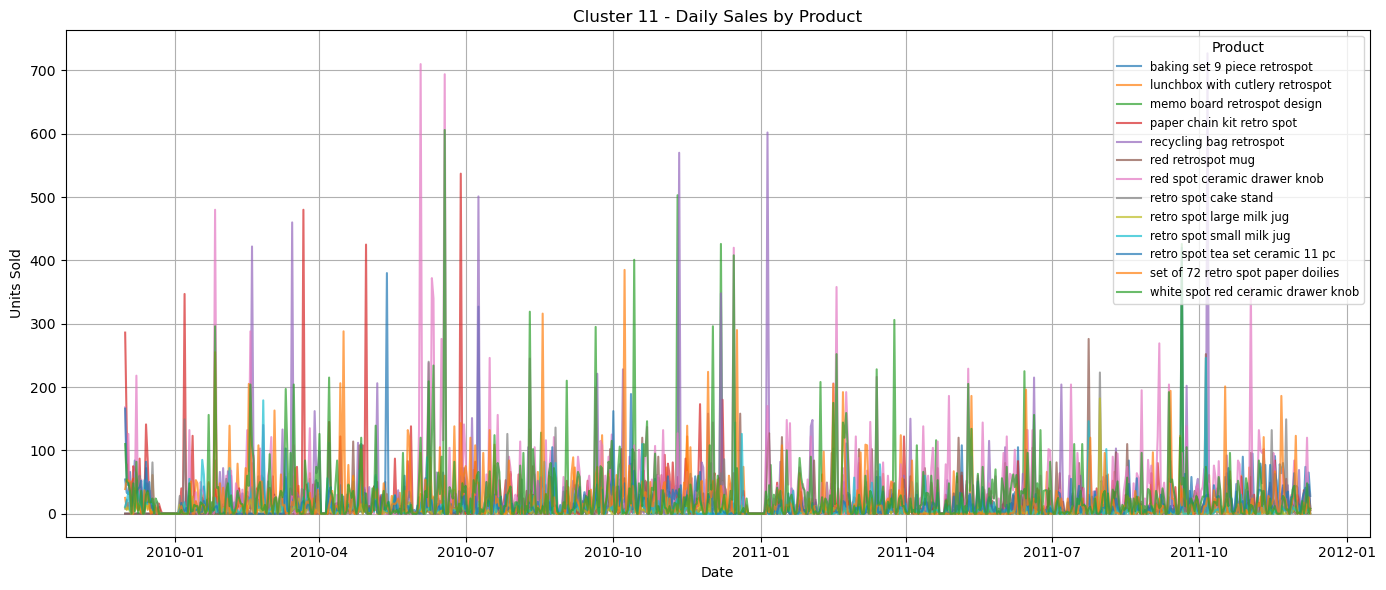

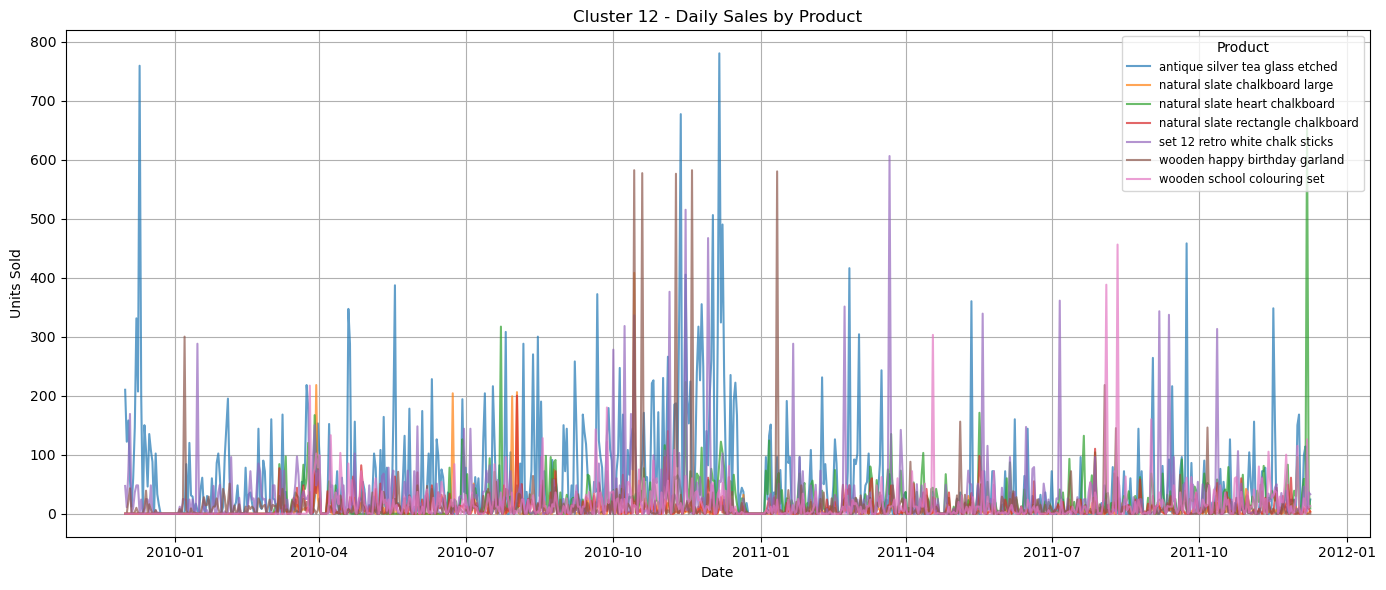

In [77]:
# Map products to clusters
product_cluster_map = pd.Series(description_df['K-Means_Cluster'])

for cluster_id in sorted(description_df['K-Means_Cluster'].unique()):
    # Filter data for current cluster
    cluster_df = df[df['K-Means_Cluster'] == cluster_id]

    # Group by Description and Date, summing UnitsSold
    grouped = cluster_df.groupby(['Description', 'Date'])['UnitsSold'].sum().unstack(fill_value=0)

    # Plot each product's time series
    plt.figure(figsize=(14, 6))
    for product in grouped.index:
        plt.plot(grouped.columns, grouped.loc[product], label=product, alpha=0.7)

    plt.title(f"Cluster {cluster_id} - Daily Sales by Product")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend(loc='upper right', fontsize='small', title='Product')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

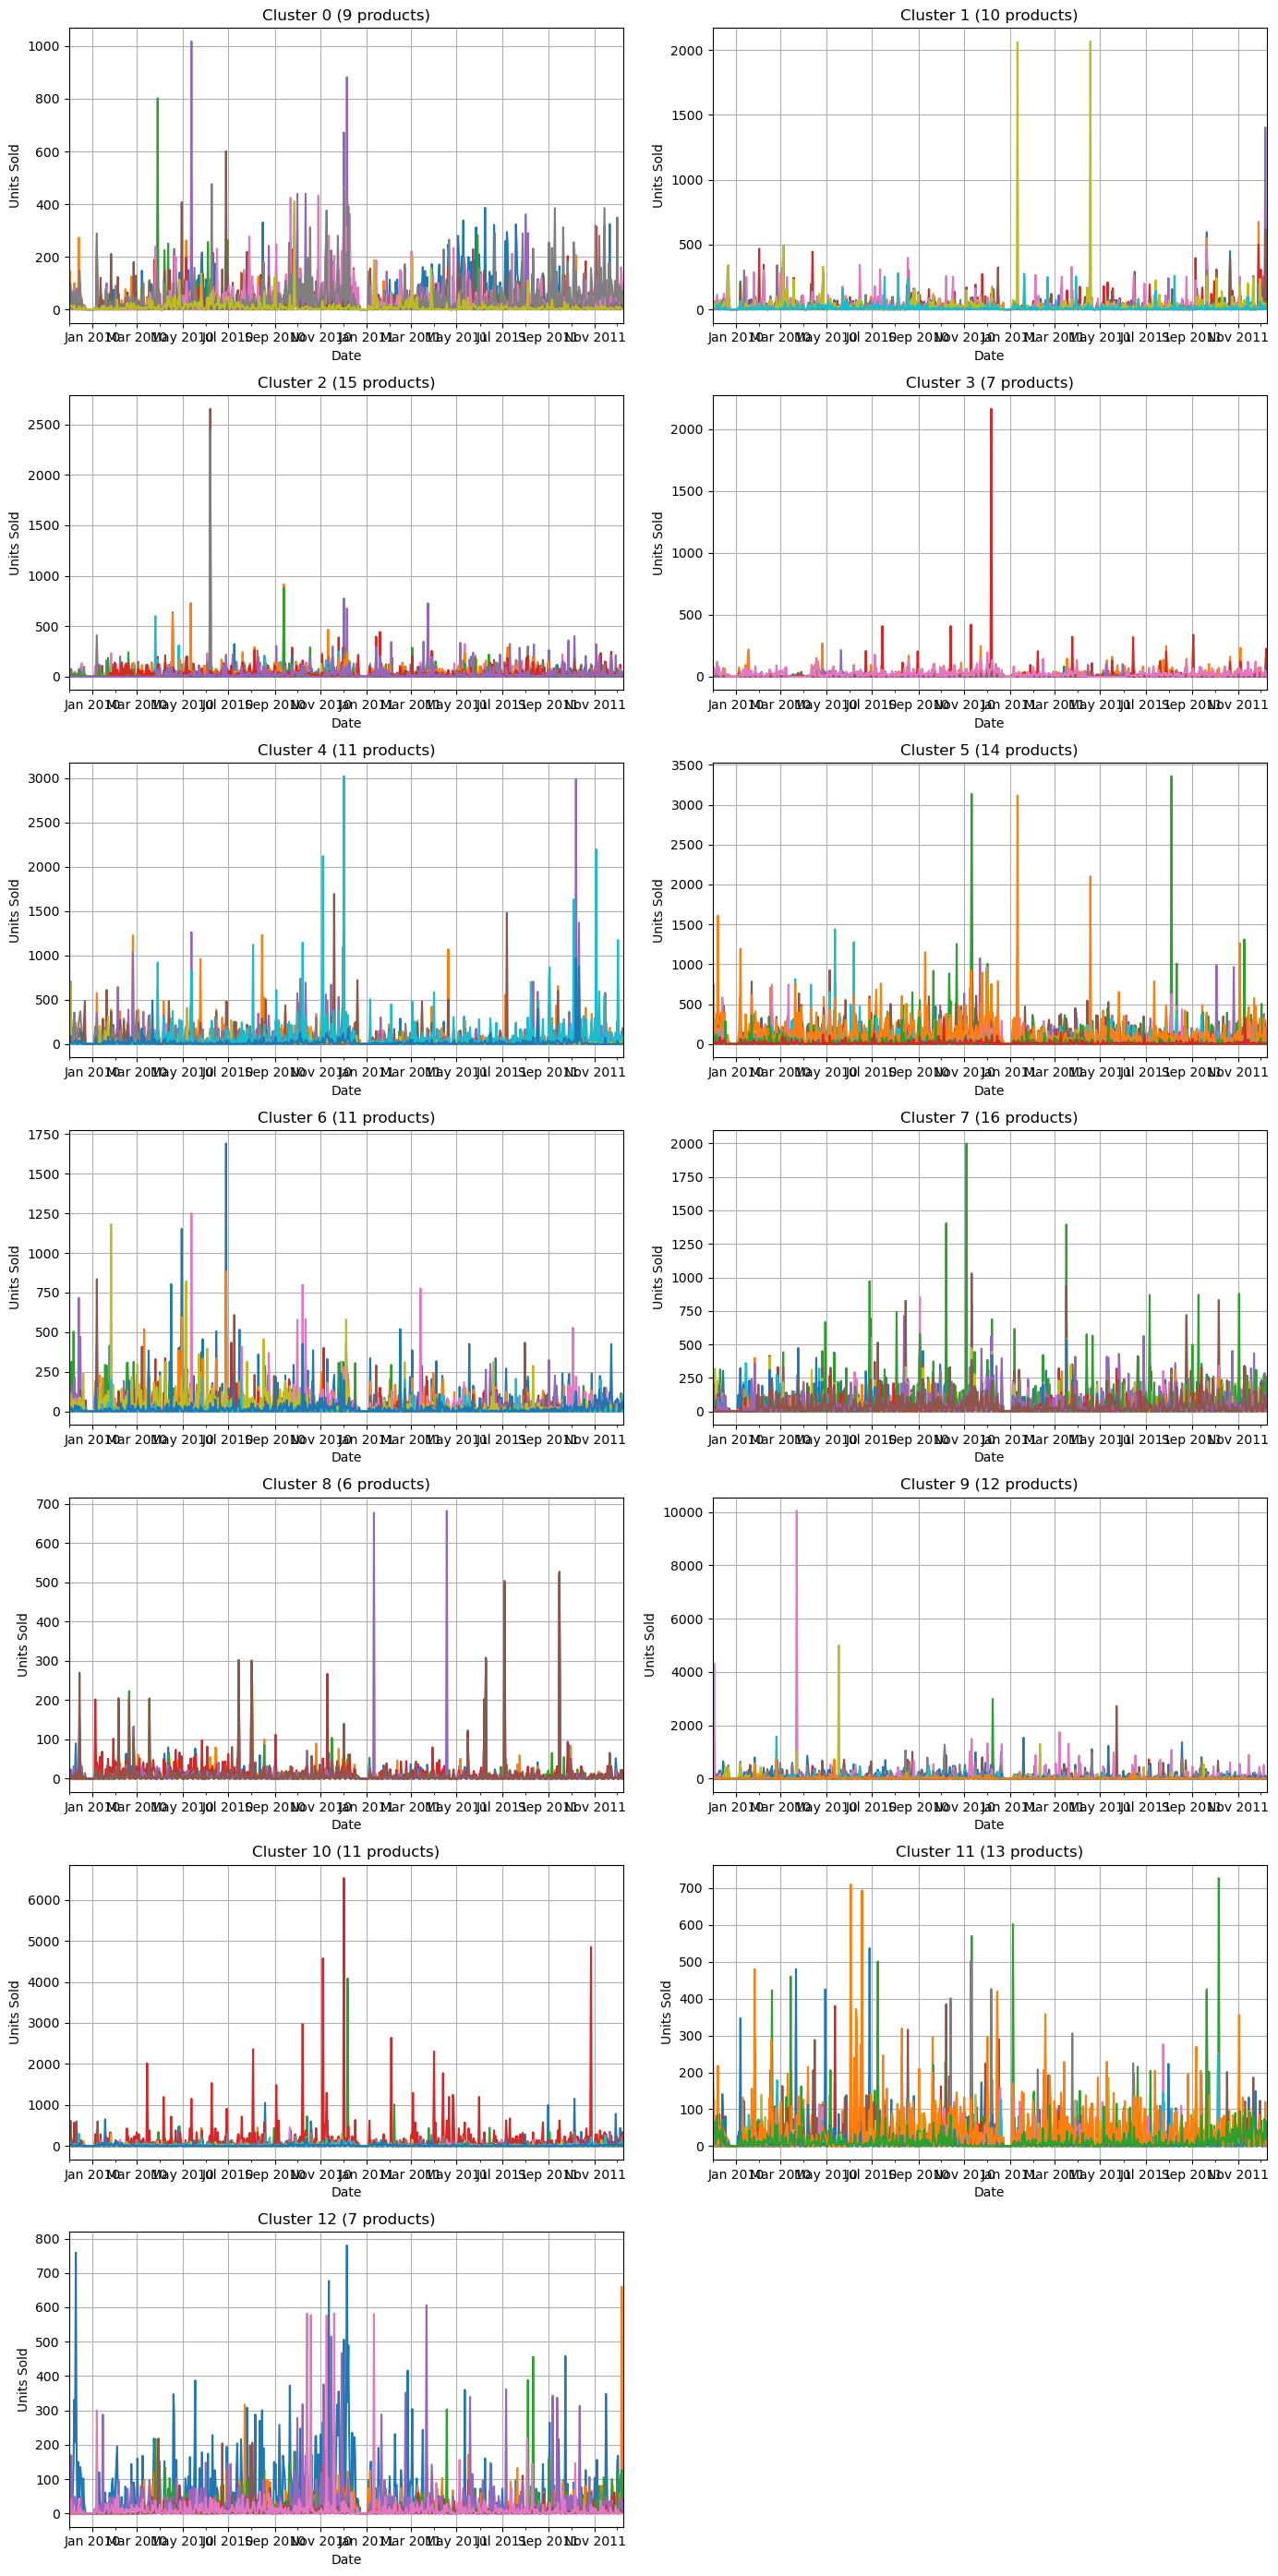

In [78]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['K-Means_Cluster'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['K-Means_Cluster'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [79]:
clusters = df.groupby('K-Means_Cluster')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- 6 ribbons rustic charm
- blue happy birthday bunting
- paper bunting retro spots
- party bunting
- regency cakestand 3 tier
- ribbon reel spots design
- vintage heads and tails card game
- vintage snap cards
- vintage union jack bunting

Cluster 1:
- bathroom metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- hand over the chocolate sign
- hot baths metal sign
- metal sign take it or leave it
- no singing metal sign
- pottering in the shed metal sign
- toilet metal sign

Cluster 2:
- baking set spaceboy design
- childs apron spaceboy design
- lunch bag black skull
- lunch bag cars blue
- lunch bag woodland
- lunchbag spaceboy design
- lunchbag suki design
- lunchbox i love london
- plasters in tin circus parade
- plasters in tin skulls
- plasters in tin spaceboy
- plasters in tin strongman
- plasters in tin vintage paisley
- plasters in tin woodland animals
- strawberry lunchbox with cutlery

Cluster 3:
- white wood garden 

# DBSCAN
(Density-Based Spatial Clustering of Applications with Noise)

In [80]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

In [84]:
def tune_dbscan(embeddings, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_labels = None
    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(embeddings)

            # Skip if all points are noise or only one cluster
            if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
                continue

            embeddings = np.array(embeddings)

            mask = labels != -1
            filtered_embeddings = embeddings[mask]
            filtered_labels = labels[mask]

            # Skip if only one cluster remains after filtering
            if len(set(filtered_labels)) <= 1:
                continue

            score = silhouette_score(filtered_embeddings, filtered_labels)
            print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.4f}")

            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

    if best_params is None:
        print("\n❌ No valid clusters found.")
        return None, None, None

    print(f"\n✅ Best Params: eps={best_params[0]}, min_samples={best_params[1]}, silhouette_score={best_score:.4f}")
    return best_labels, best_params, pd.DataFrame(results)


In [85]:
eps_range = np.linspace(0.3, 10.0, 30)
min_samples_range = list(range(2, 15))

In [86]:
labels, best_params, results_df = tune_dbscan(embeddings, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.7584
eps=0.6344827586206896, min_samples=2, silhouette_score=0.1495
eps=0.6344827586206896, min_samples=3, silhouette_score=0.1582
eps=0.6344827586206896, min_samples=4, silhouette_score=0.1319
eps=0.6344827586206896, min_samples=5, silhouette_score=0.1297
eps=0.6344827586206896, min_samples=6, silhouette_score=0.1526
eps=0.6344827586206896, min_samples=7, silhouette_score=0.1765
eps=0.6344827586206896, min_samples=8, silhouette_score=0.2827

✅ Best Params: eps=0.3, min_samples=2, silhouette_score=0.7584


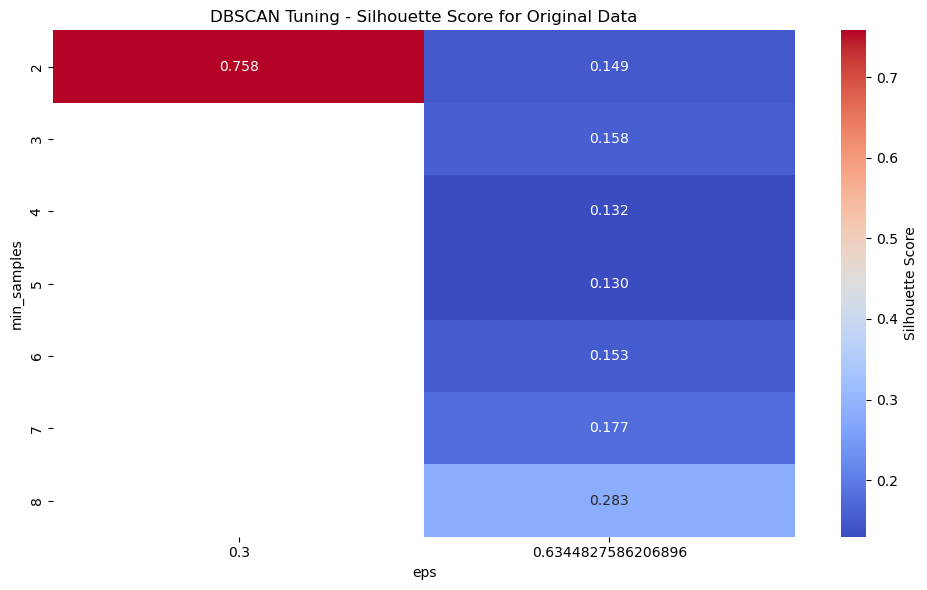

In [87]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for Original Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [88]:
labels, best_params, results_df = tune_dbscan(reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.1573
eps=0.3, min_samples=3, silhouette_score=0.1983
eps=0.3, min_samples=4, silhouette_score=0.1983
eps=0.3, min_samples=5, silhouette_score=0.2546
eps=0.3, min_samples=6, silhouette_score=0.2389
eps=0.3, min_samples=7, silhouette_score=0.2630
eps=0.3, min_samples=8, silhouette_score=0.2903
eps=0.3, min_samples=9, silhouette_score=0.3010
eps=0.3, min_samples=10, silhouette_score=0.3334
eps=0.3, min_samples=11, silhouette_score=0.3419
eps=0.3, min_samples=12, silhouette_score=0.3589
eps=0.3, min_samples=13, silhouette_score=0.3610

✅ Best Params: eps=0.3, min_samples=13, silhouette_score=0.3610


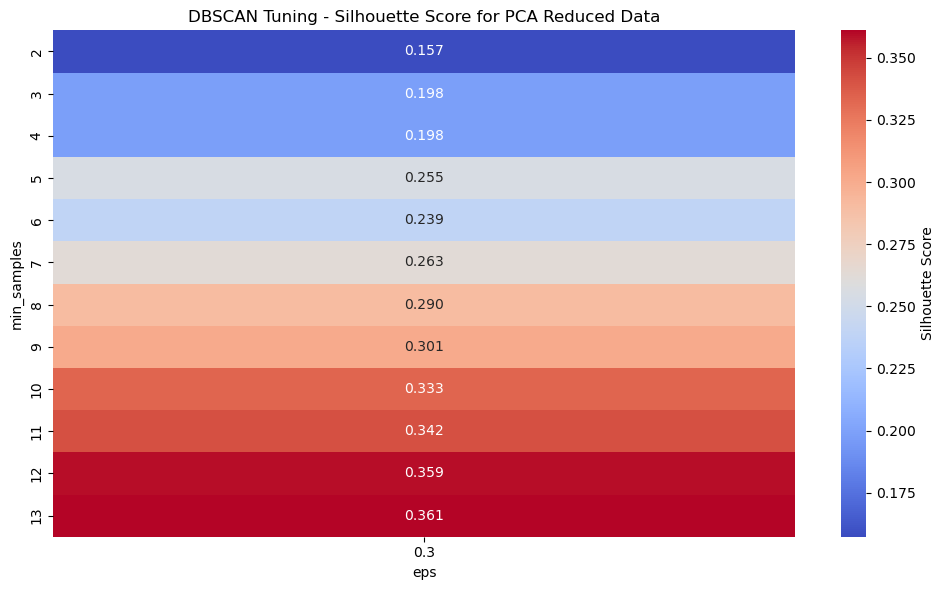

In [89]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [90]:
labels, best_params, results_df = tune_dbscan(umap_reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.6161
eps=0.3, min_samples=3, silhouette_score=0.6801
eps=0.3, min_samples=4, silhouette_score=0.6709
eps=0.3, min_samples=5, silhouette_score=0.8190
eps=0.3, min_samples=6, silhouette_score=0.8534
eps=0.3, min_samples=7, silhouette_score=0.8840
eps=0.3, min_samples=8, silhouette_score=0.8821
eps=0.6344827586206896, min_samples=2, silhouette_score=0.0090
eps=0.6344827586206896, min_samples=3, silhouette_score=0.0090
eps=0.6344827586206896, min_samples=4, silhouette_score=0.0090
eps=0.6344827586206896, min_samples=5, silhouette_score=0.1930
eps=0.6344827586206896, min_samples=6, silhouette_score=0.1916
eps=0.6344827586206896, min_samples=7, silhouette_score=0.2570
eps=0.6344827586206896, min_samples=8, silhouette_score=0.5117
eps=0.6344827586206896, min_samples=9, silhouette_score=0.5877
eps=0.6344827586206896, min_samples=10, silhouette_score=0.6435
eps=0.6344827586206896, min_samples=11, silhouette_score=0.7076
eps=0.6344827586206896, min_samp

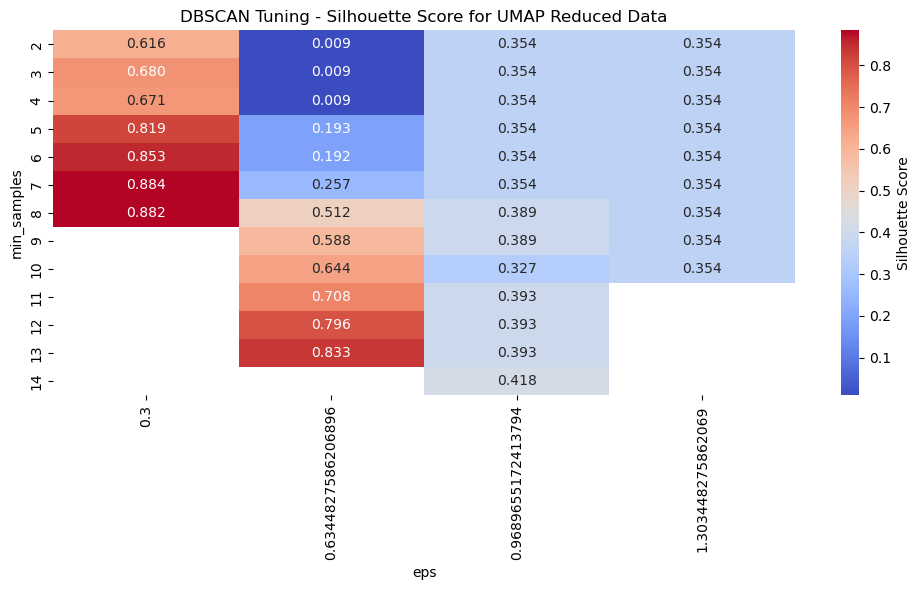

In [91]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [92]:
description_df['DBScan'] = labels

In [93]:
df = df.merge(
    description_df[['Description', 'DBScan']],
    left_on='Description',
    right_on='Description',
    how='left'
)

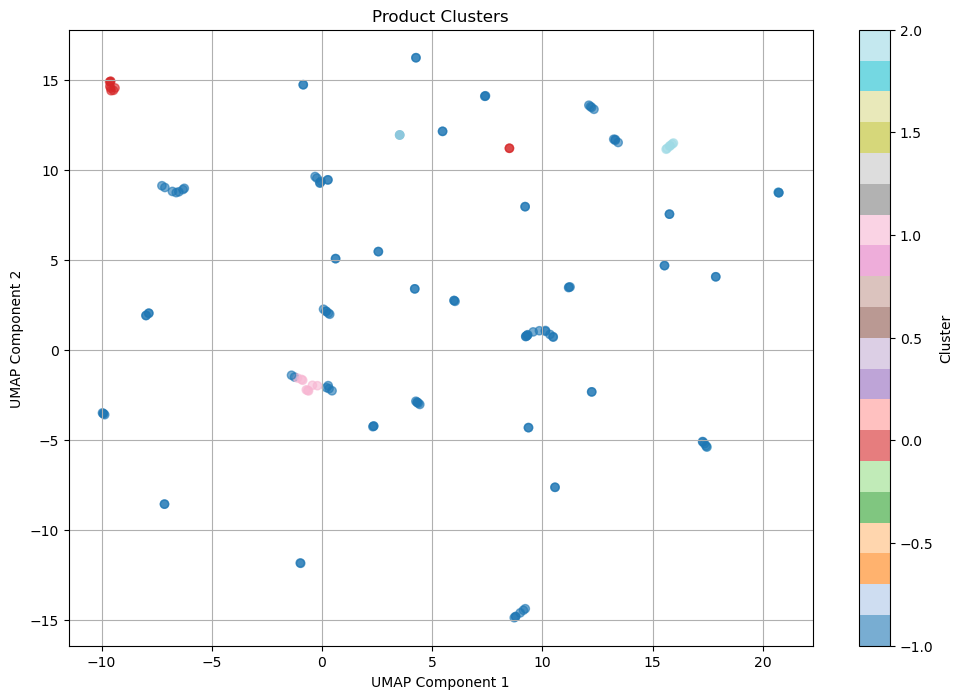

In [94]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['DBScan'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

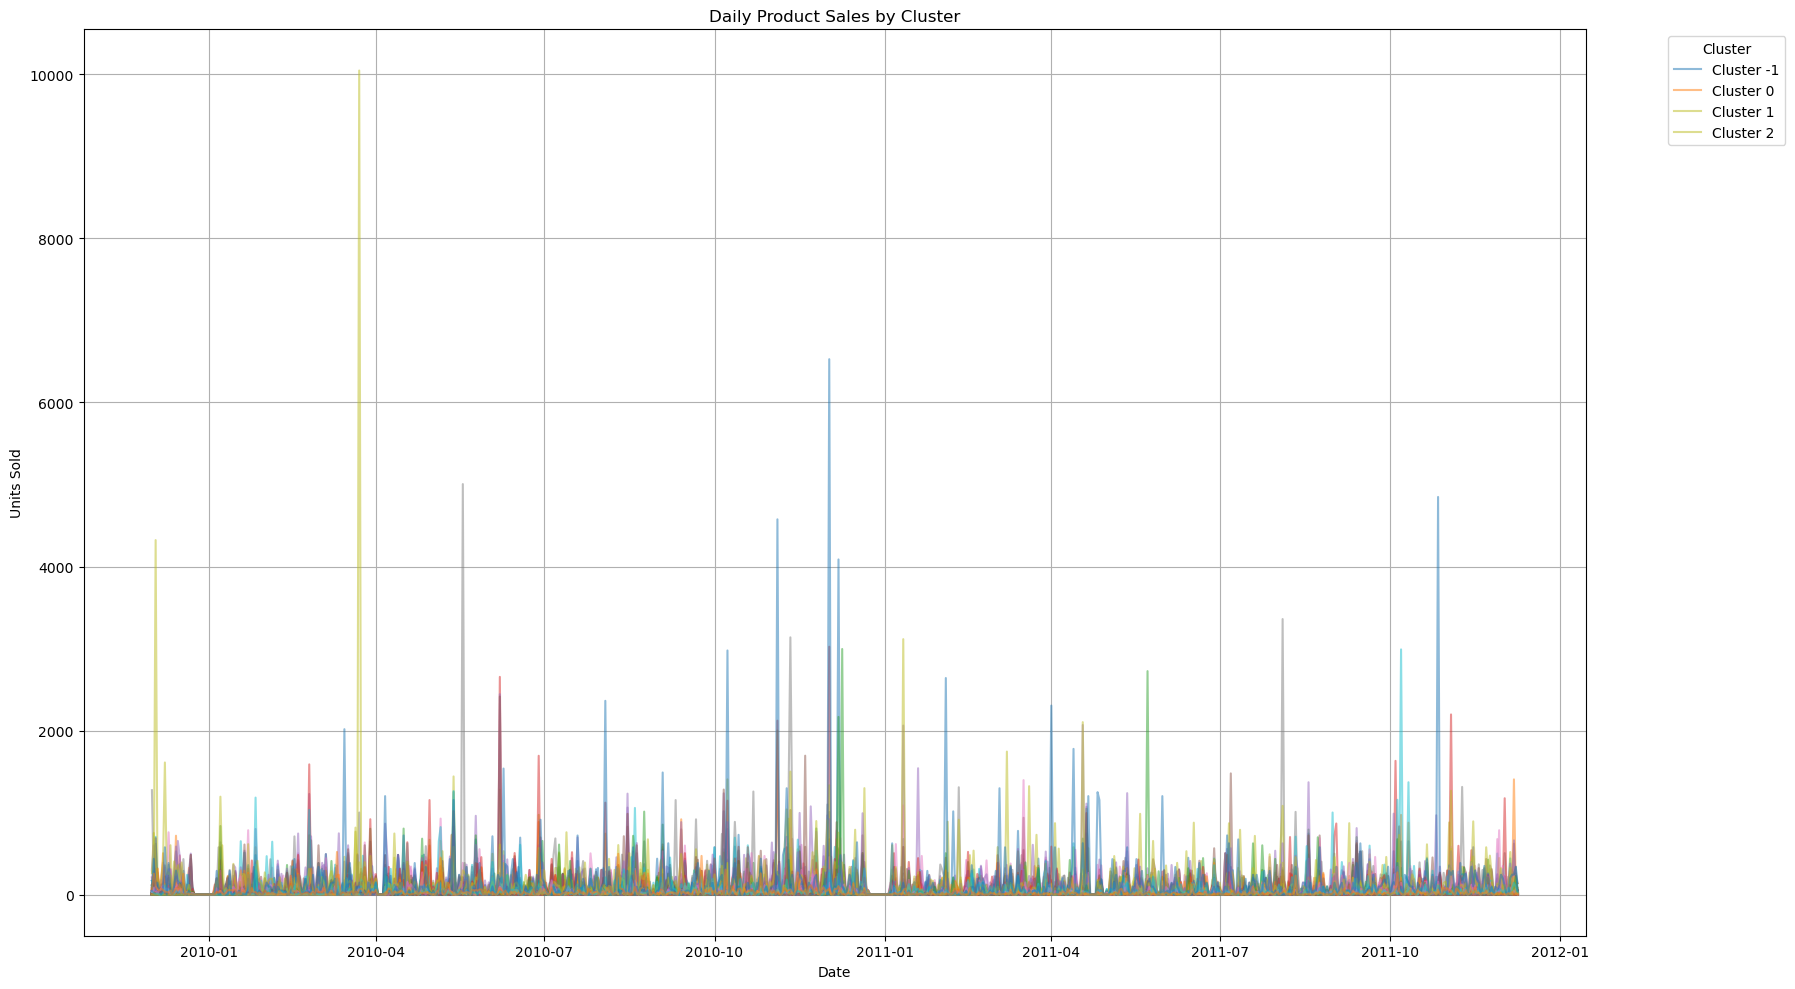

In [95]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'DBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\brian\AppData\Local\Temp\ipykernel_15084\1380680039.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


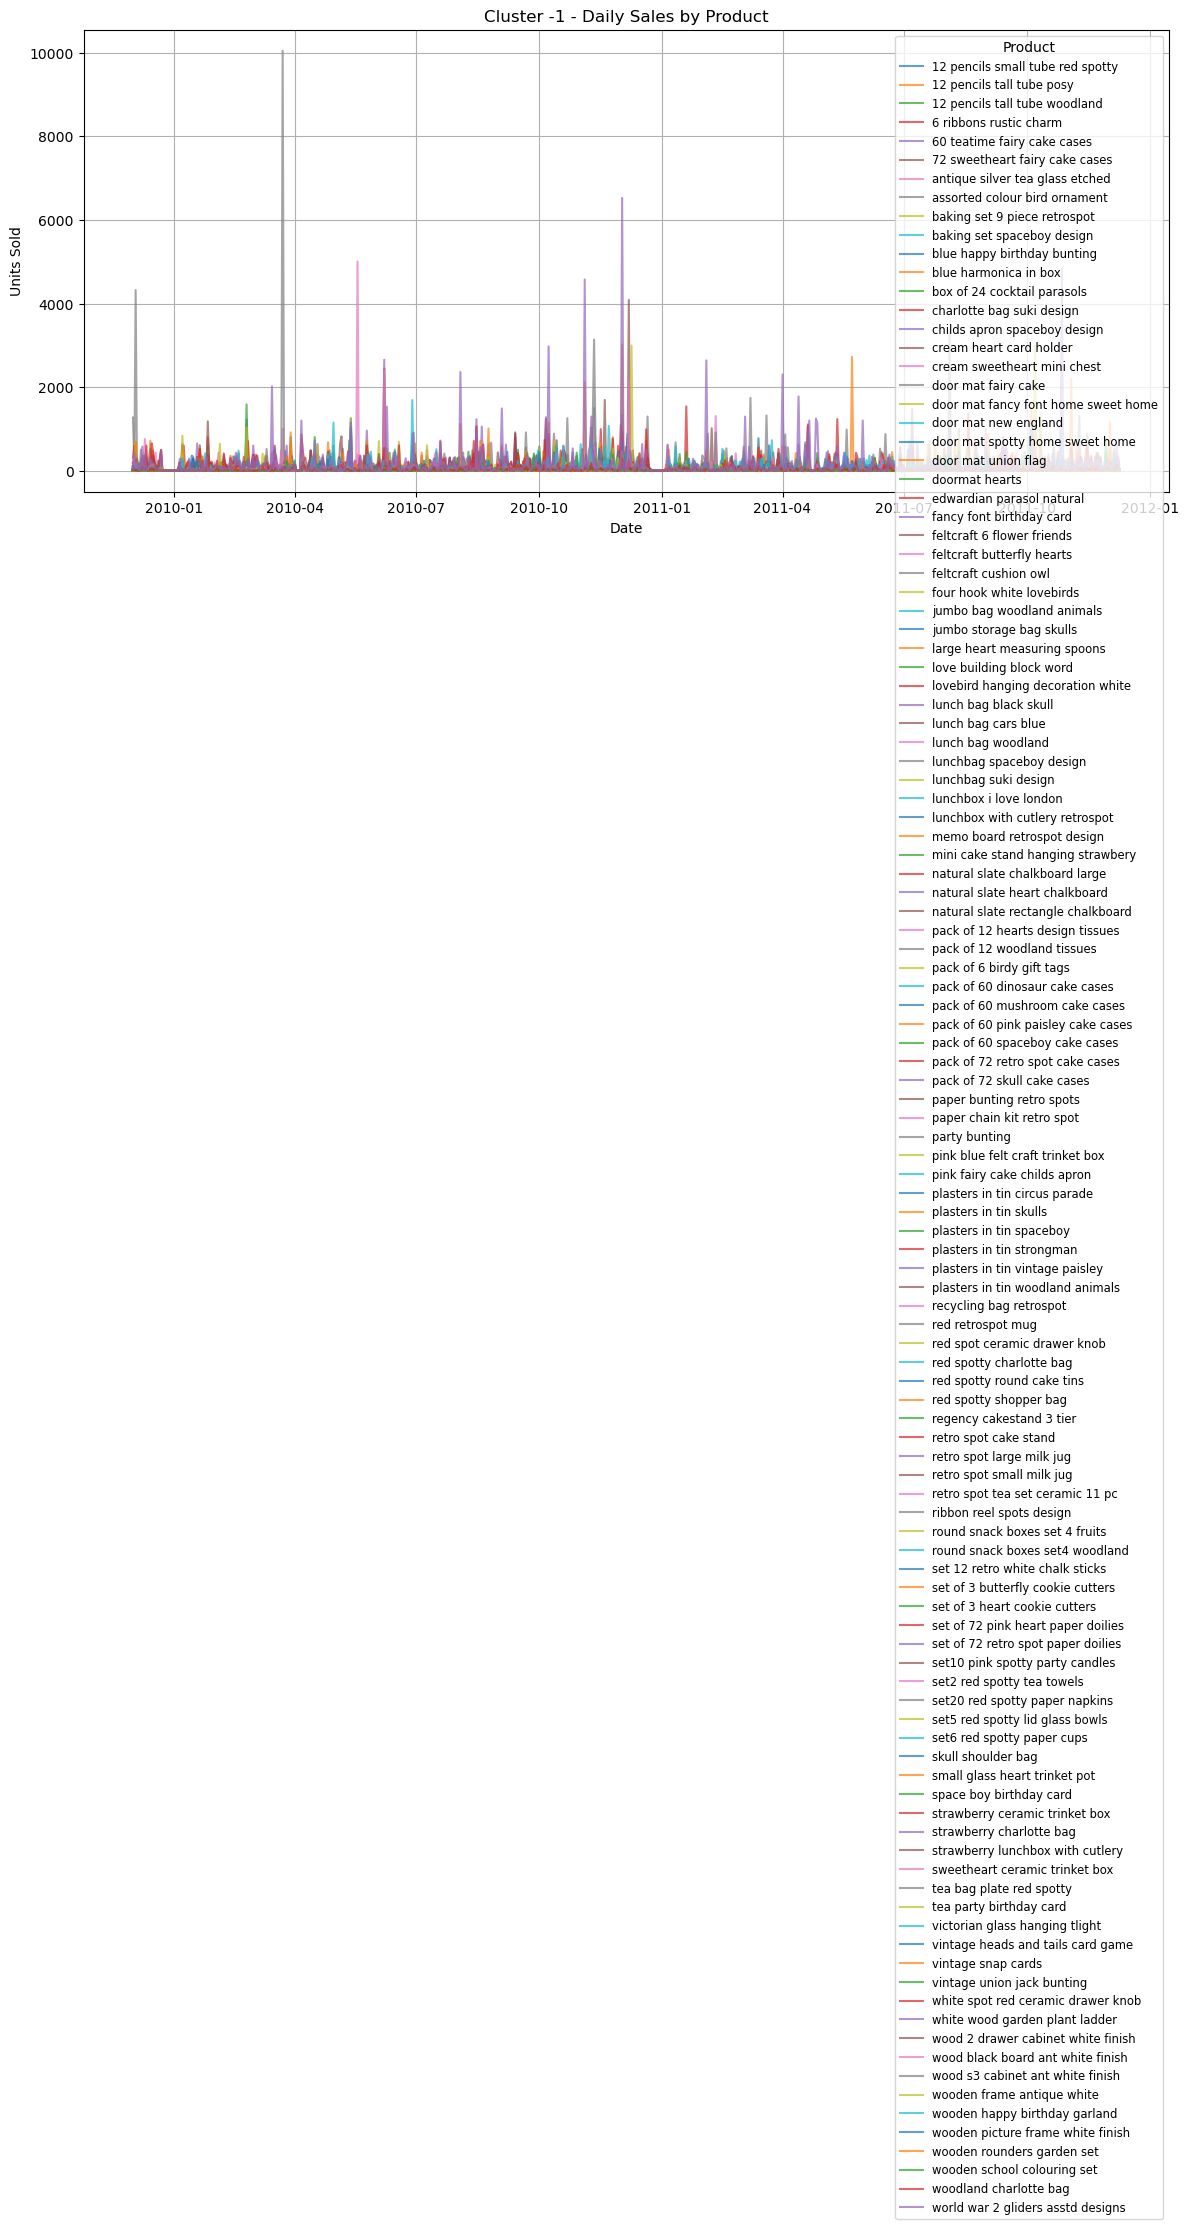

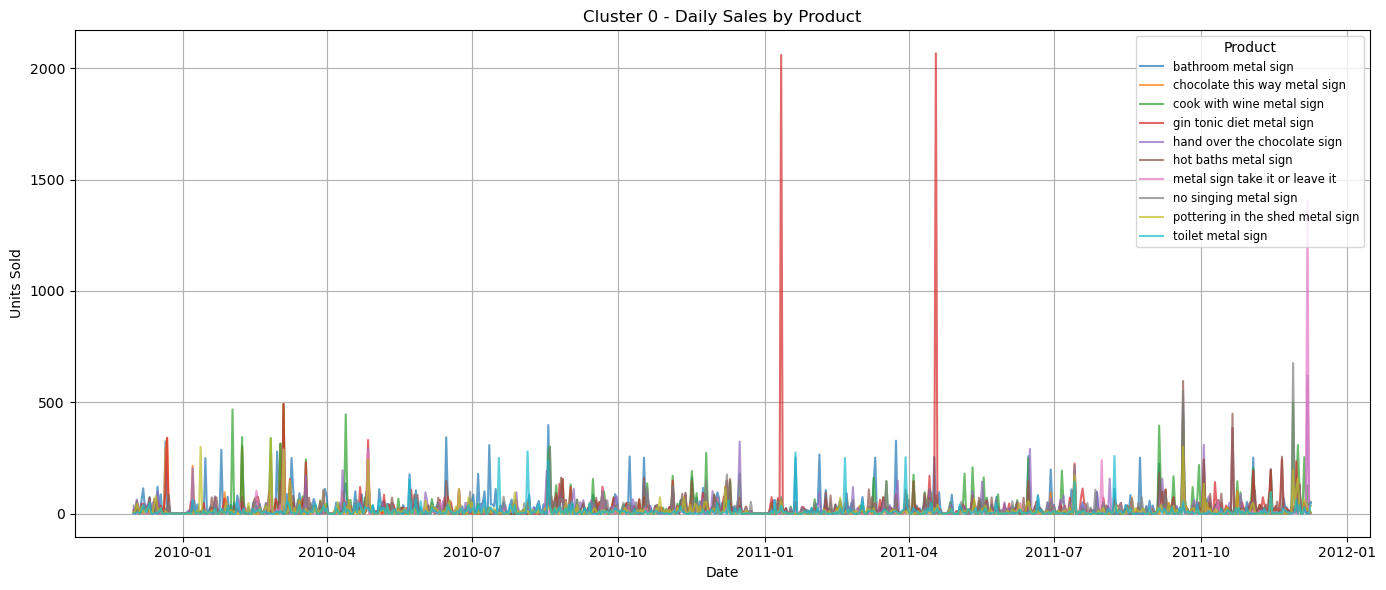

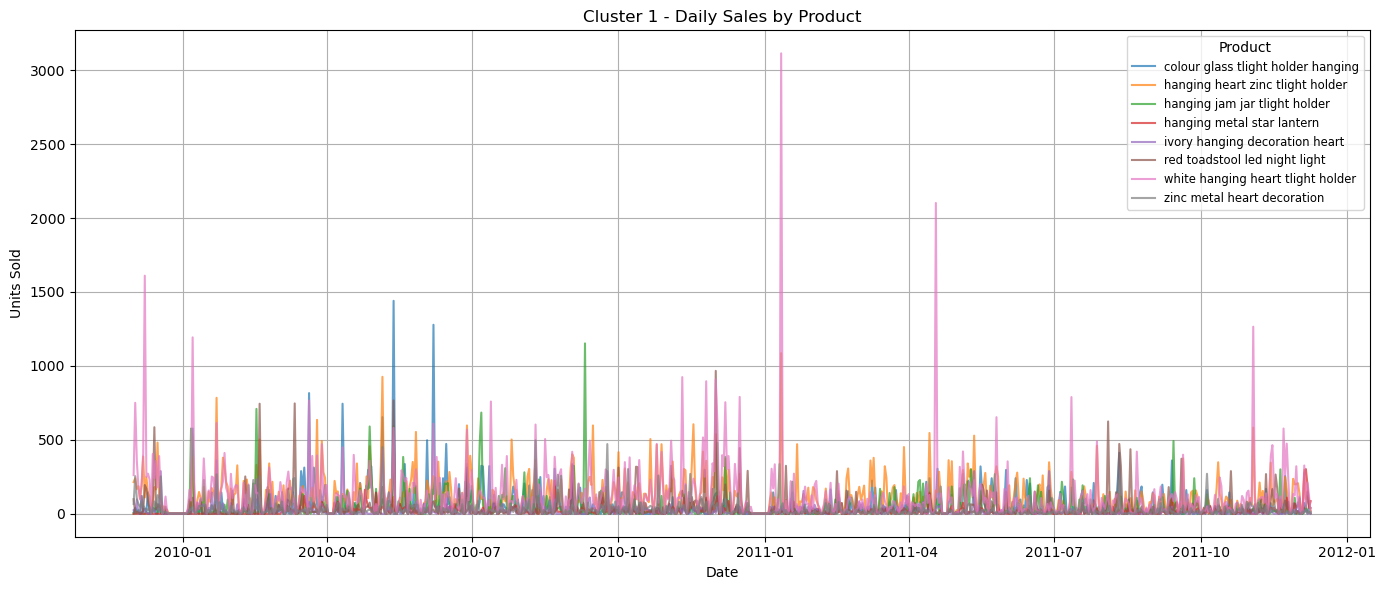

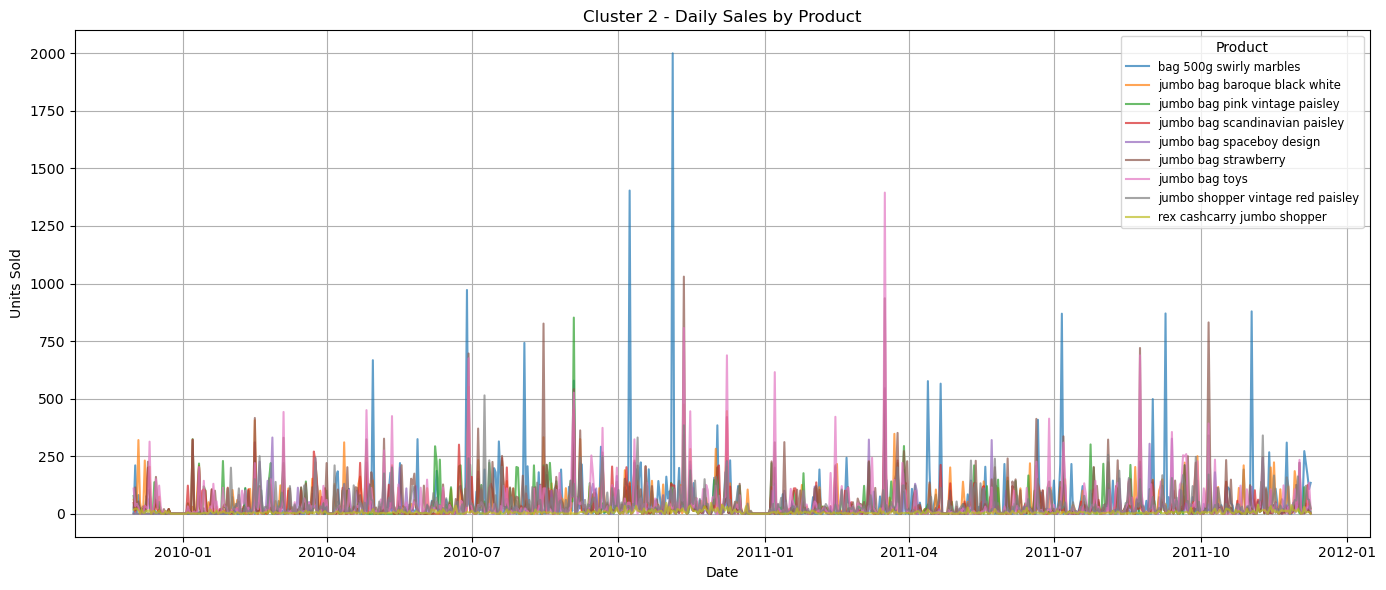

In [96]:
# Map products to clusters
product_cluster_map = pd.Series(description_df['DBScan'])

for cluster_id in sorted(description_df['DBScan'].unique()):
    # Filter data for current cluster
    cluster_df = df[df['DBScan'] == cluster_id]

    # Group by Description and Date, summing UnitsSold
    grouped = cluster_df.groupby(['Description', 'Date'])['UnitsSold'].sum().unstack(fill_value=0)

    # Plot each product's time series
    plt.figure(figsize=(14, 6))
    for product in grouped.index:
        plt.plot(grouped.columns, grouped.loc[product], label=product, alpha=0.7)

    plt.title(f"Cluster {cluster_id} - Daily Sales by Product")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend(loc='upper right', fontsize='small', title='Product')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [97]:
clusters = df.groupby('DBScan')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster -1:
- 12 pencils small tube red spotty
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- 6 ribbons rustic charm
- 60 teatime fairy cake cases
- 72 sweetheart fairy cake cases
- antique silver tea glass etched
- assorted colour bird ornament
- baking set 9 piece retrospot
- baking set spaceboy design
- blue happy birthday bunting
- blue harmonica in box
- box of 24 cocktail parasols
- charlotte bag suki design
- childs apron spaceboy design
- cream heart card holder
- cream sweetheart mini chest
- door mat fairy cake
- door mat fancy font home sweet home
- door mat new england
- door mat spotty home sweet home
- door mat union flag
- doormat hearts
- edwardian parasol natural
- fancy font birthday card
- feltcraft 6 flower friends
- feltcraft butterfly hearts
- feltcraft cushion owl
- four hook white lovebirds
- jumbo bag woodland animals
- jumbo storage bag skulls
- large heart measuring spoons
- love building block word
- lovebird hanging decoration white
- lunch b

# HDBSCAN (Hierarchical DBSCAN)

In [17]:
import hdbscan

In [18]:
def tune_hdbscan(embeddings, min_cluster_sizes):
    best_score = -1
    best_params = None
    best_labels = None
    scores = []
    min_clusters = []

    for size in min_cluster_sizes:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        labels = clusterer.fit_predict(embeddings)

        # Skip runs with only one cluster or all noise
        unique_labels = set(labels)
        if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
            continue

        embeddings = np.array(embeddings)

        mask = labels != -1
        filtered_embeddings = embeddings[mask]
        filtered_labels = labels[mask]

        # Skip if only one cluster remains after filtering
        if len(set(filtered_labels)) <= 1:
            continue

        score = silhouette_score(filtered_embeddings, filtered_labels)
        print(f"min_cluster_size={size}, silhouette_score={score:.4f}")

        scores.append(score)
        min_clusters.append(size)

        if score > best_score:
            best_score = score
            best_params = size
            best_labels = labels

    if best_params is None:
        print("\n❌ No valid clustering found.")
        return None, None

    print(f"\n✅ Best min_cluster_size: {best_params} with silhouette_score={best_score:.4f}")
    return best_labels, best_params, scores, min_clusters

In [21]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(embeddings, min_cluster_sizes)

min_cluster_size=2, silhouette_score=0.2147
min_cluster_size=3, silhouette_score=0.0615
min_cluster_size=4, silhouette_score=0.0622
min_cluster_size=5, silhouette_score=0.0706
min_cluster_size=6, silhouette_score=0.0796
min_cluster_size=7, silhouette_score=0.0929
min_cluster_size=8, silhouette_score=0.1010

✅ Best min_cluster_size: 2 with silhouette_score=0.2147


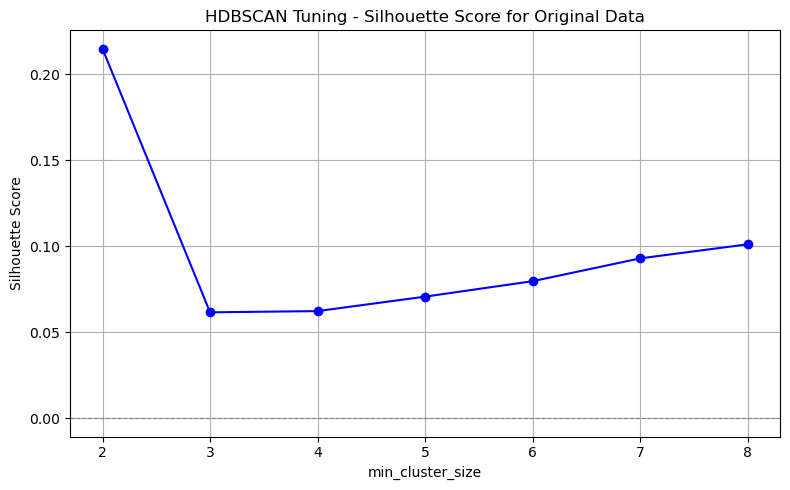

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for Original Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(reduced, min_cluster_sizes)

min_cluster_size=2, silhouette_score=0.3468
min_cluster_size=3, silhouette_score=0.3383
min_cluster_size=4, silhouette_score=0.2868
min_cluster_size=5, silhouette_score=0.3347
min_cluster_size=6, silhouette_score=0.3557
min_cluster_size=7, silhouette_score=0.3975
min_cluster_size=8, silhouette_score=0.2224
min_cluster_size=9, silhouette_score=0.2497
min_cluster_size=10, silhouette_score=0.2787

✅ Best min_cluster_size: 7 with silhouette_score=0.3975


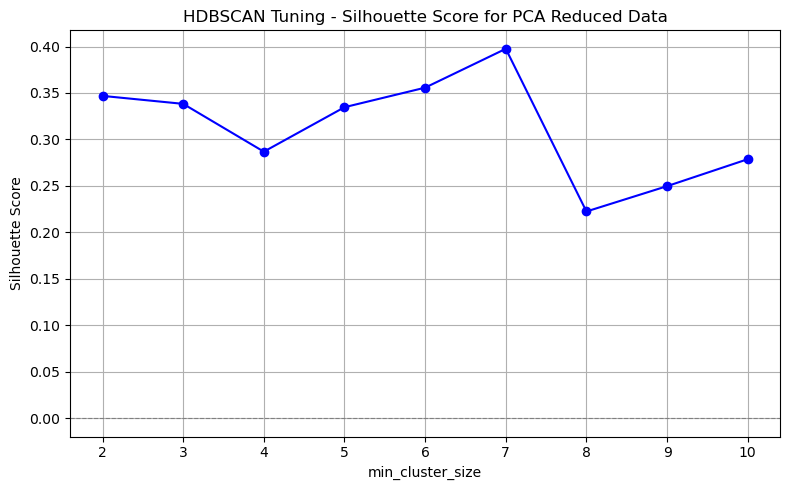

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(umap_reduced, min_cluster_sizes)


min_cluster_size=2, silhouette_score=0.5858
min_cluster_size=3, silhouette_score=0.6147
min_cluster_size=4, silhouette_score=0.6672
min_cluster_size=5, silhouette_score=0.2136
min_cluster_size=6, silhouette_score=0.3542
min_cluster_size=7, silhouette_score=0.3542
min_cluster_size=8, silhouette_score=0.3542
min_cluster_size=9, silhouette_score=0.3542
min_cluster_size=10, silhouette_score=0.4496
min_cluster_size=11, silhouette_score=0.4859
min_cluster_size=12, silhouette_score=0.4918
min_cluster_size=13, silhouette_score=0.5088
min_cluster_size=14, silhouette_score=0.5374
min_cluster_size=15, silhouette_score=0.5321

✅ Best min_cluster_size: 4 with silhouette_score=0.6672


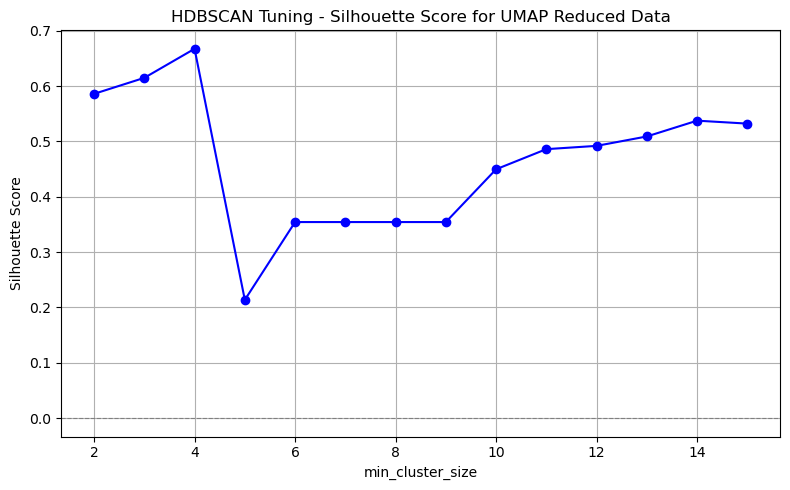

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
description_df['HDBScan'] = labels

In [28]:
df = df.merge(
    description_df[['Description', 'HDBScan']],
    left_on='Description',
    right_on='Description',
    how='left'
)

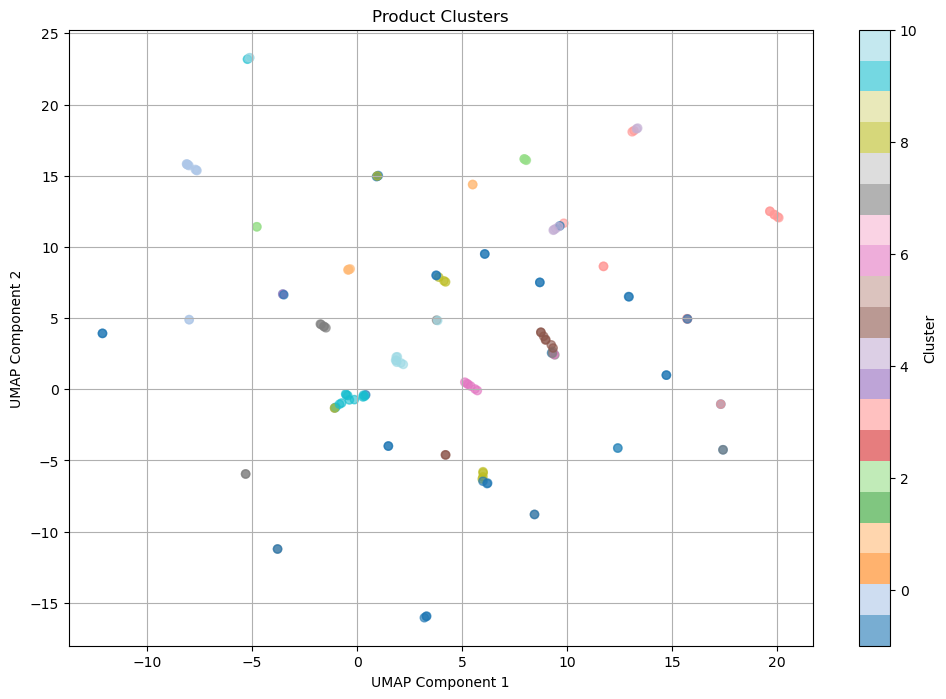

In [29]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['HDBScan'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

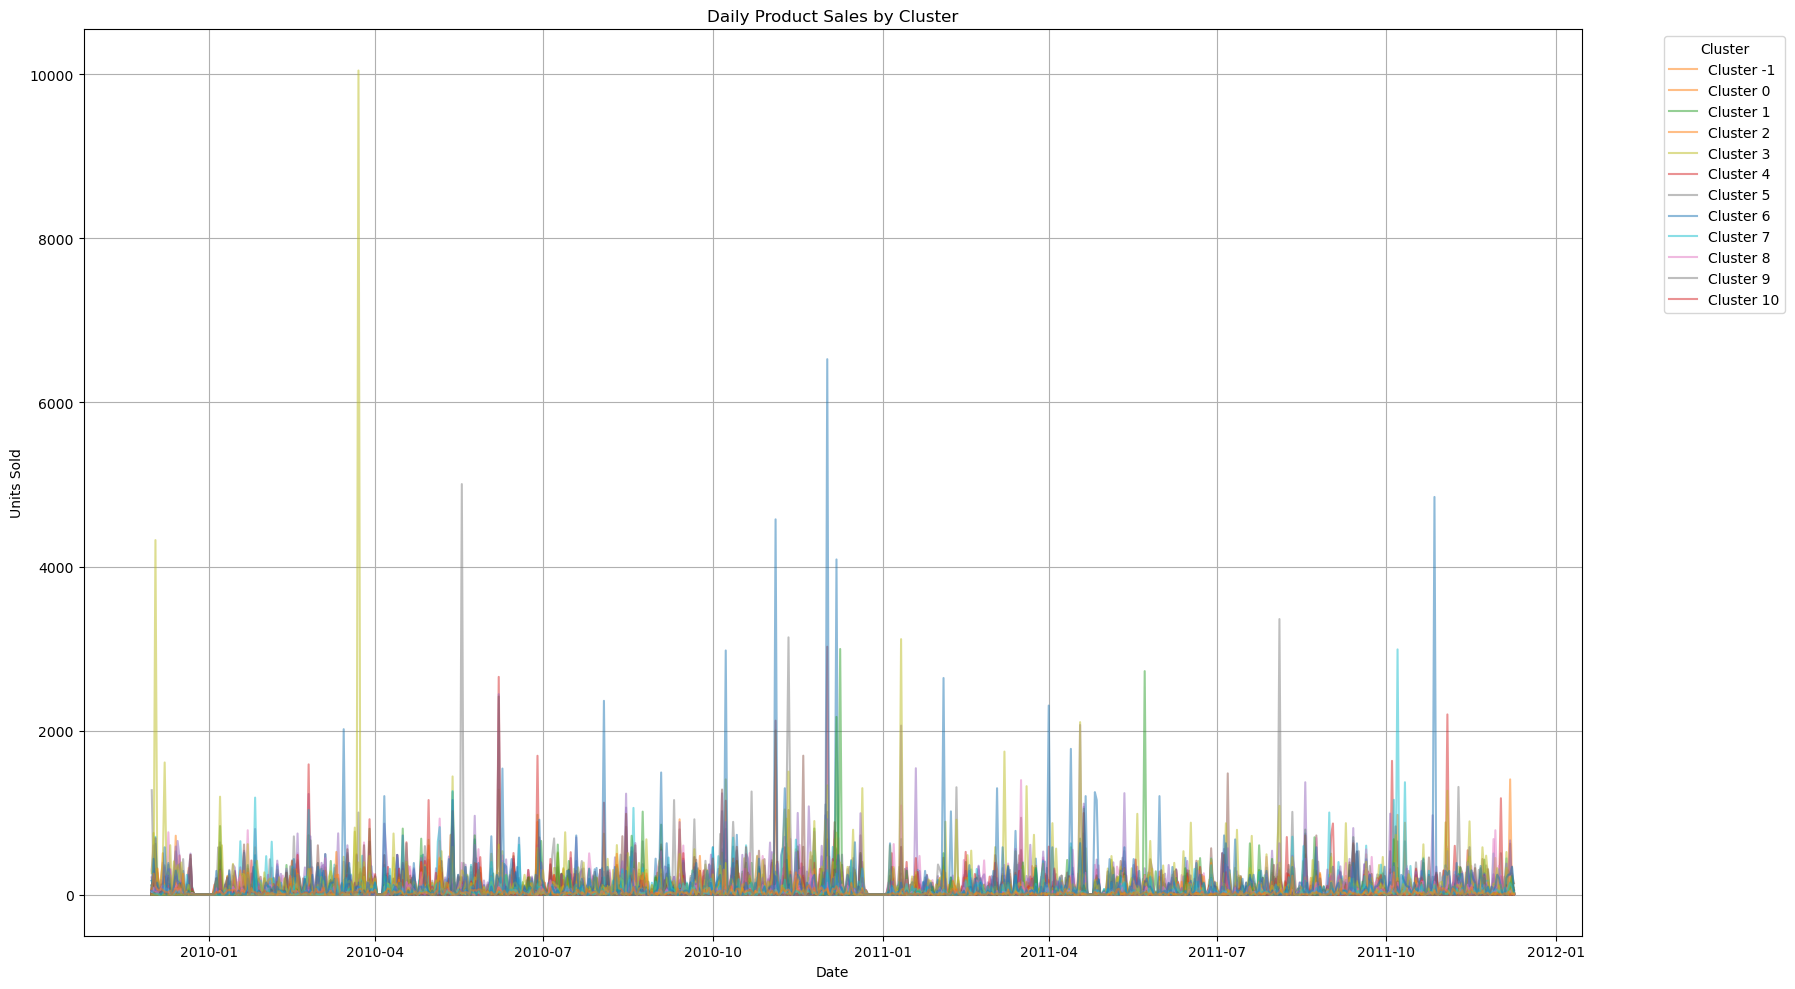

In [30]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'HDBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

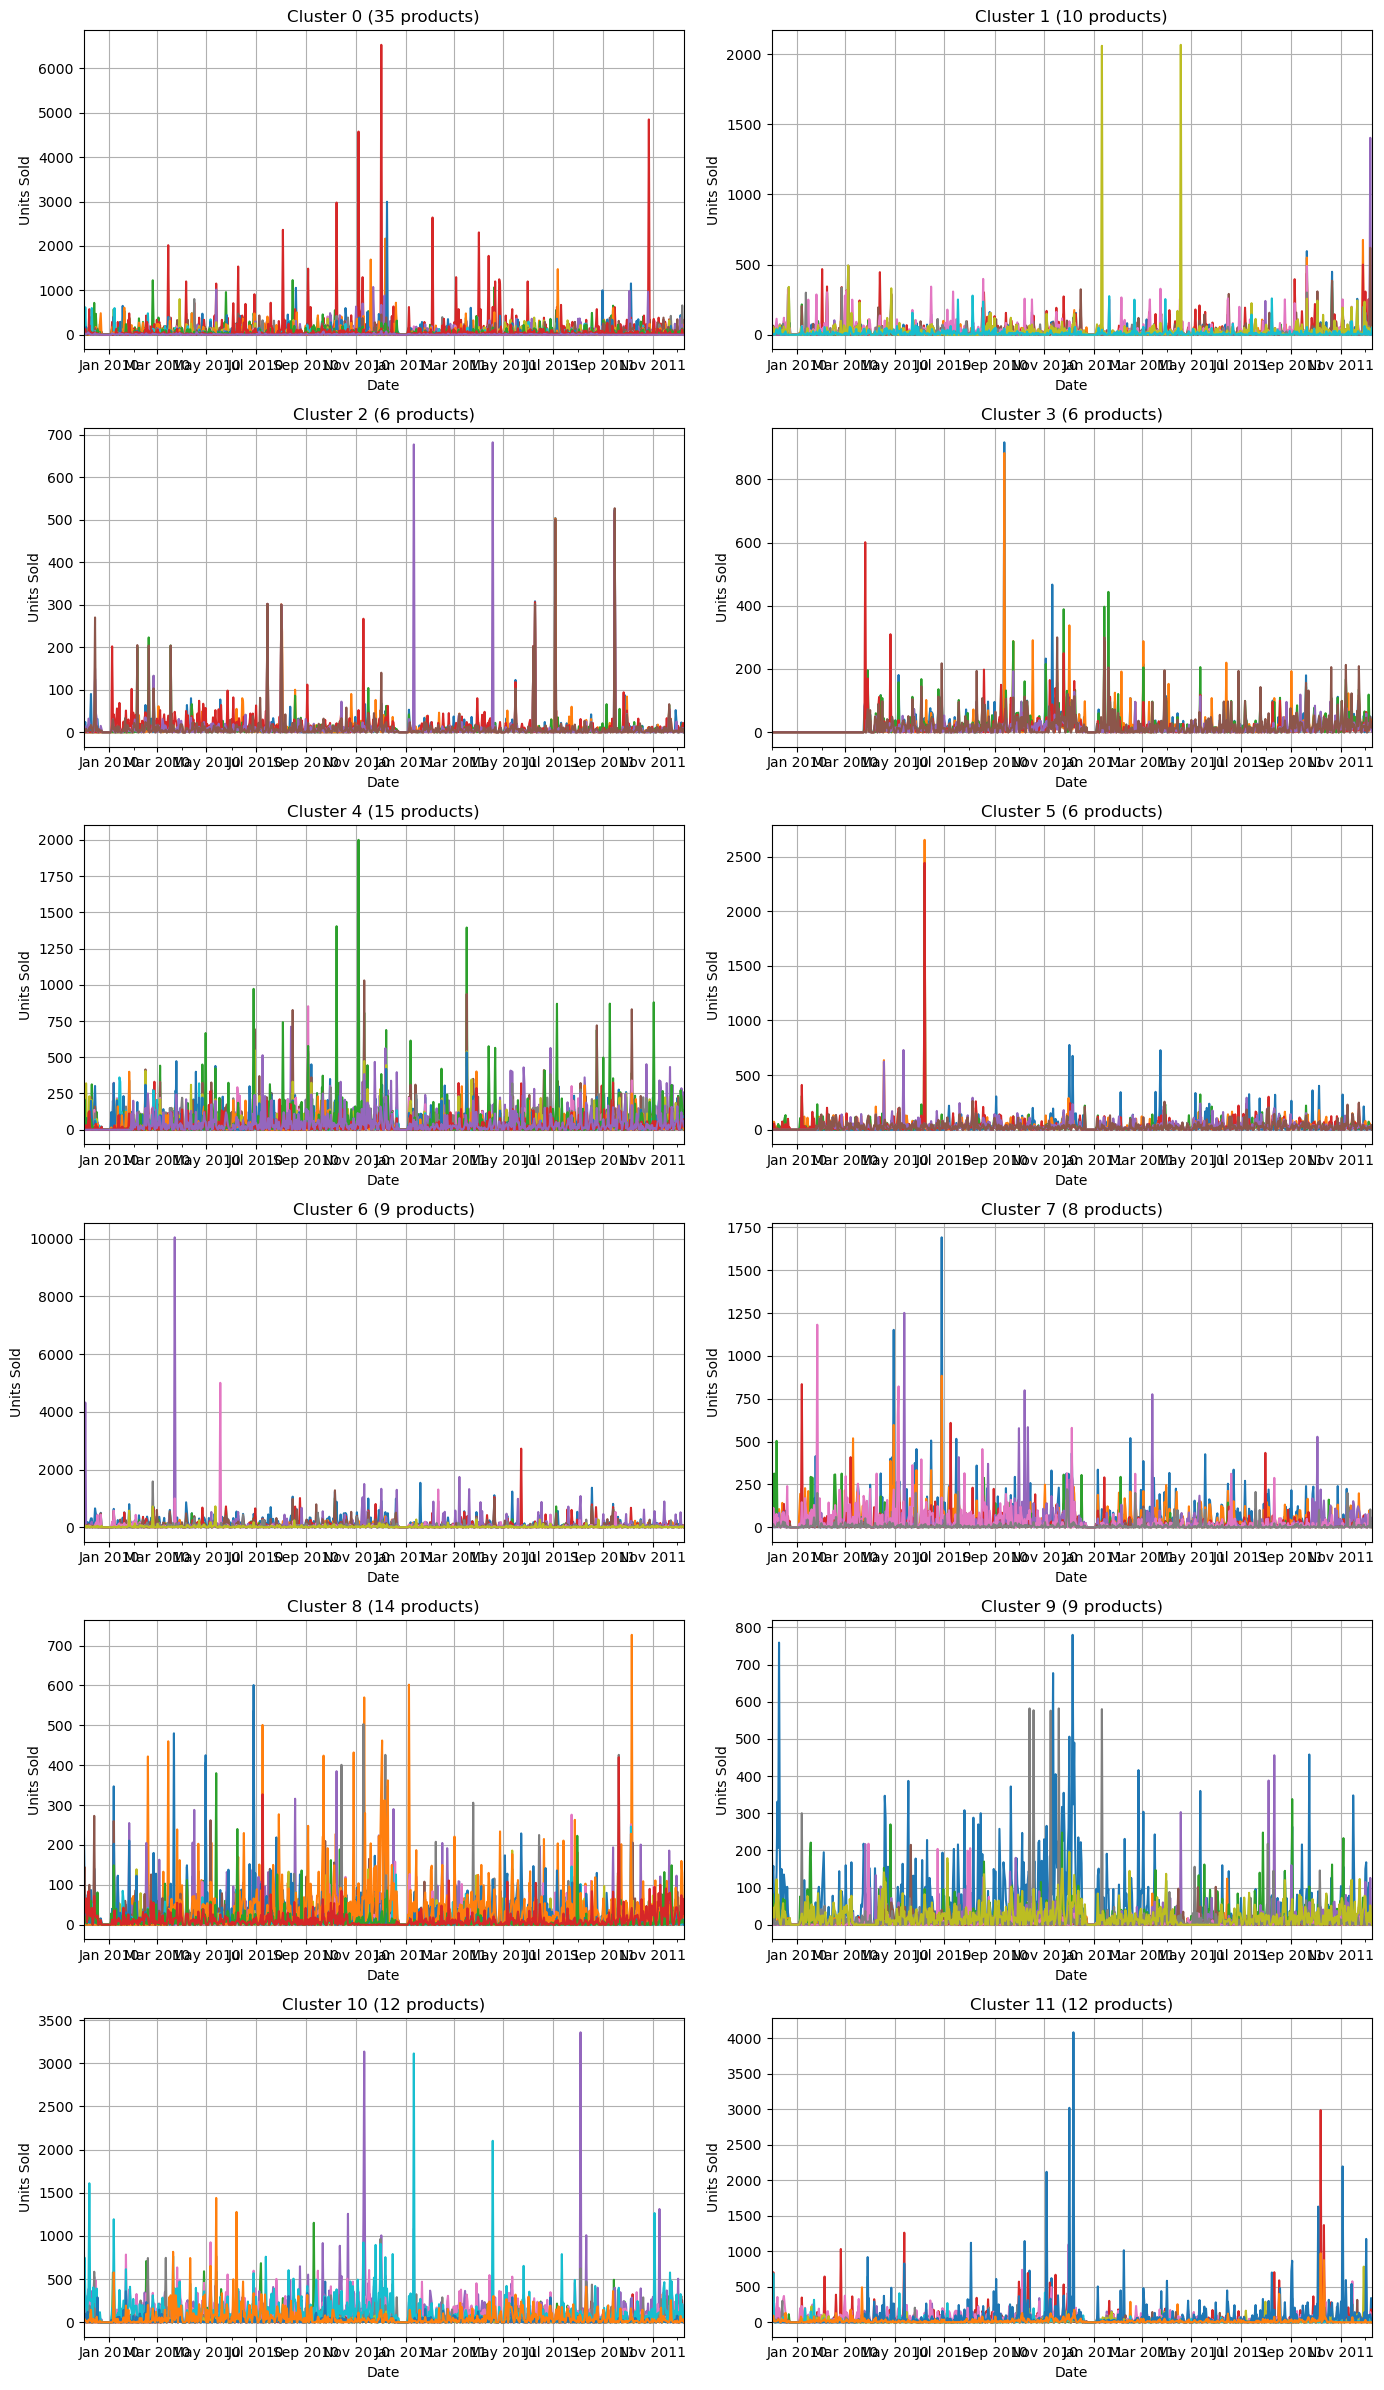

In [112]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['HDBScan'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['HDBScan'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [113]:
clusters = df.groupby('HDBScan')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster -1:
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- 6 ribbons rustic charm
- 60 teatime fairy cake cases
- 72 sweetheart fairy cake cases
- baking set spaceboy design
- blue happy birthday bunting
- box of 24 cocktail parasols
- childs apron spaceboy design
- edwardian parasol natural
- fancy font birthday card
- four hook white lovebirds
- mini cake stand hanging strawbery
- natural slate heart chalkboard
- natural slate rectangle chalkboard
- party bunting
- pink fairy cake childs apron
- red spot ceramic drawer knob
- red spotty shopper bag
- round snack boxes set 4 fruits
- round snack boxes set4 woodland
- set 12 retro white chalk sticks
- set of 3 butterfly cookie cutters
- space boy birthday card
- strawberry lunchbox with cutlery
- tea party birthday card
- victorian glass hanging tlight
- vintage heads and tails card game
- vintage snap cards
- vintage union jack bunting
- white spot red ceramic drawer knob
- wood black board ant white finish
- wood s3 ca

# Agglomerative (Hierarchical) Clustering

In [114]:
from sklearn.cluster import AgglomerativeClustering

In [115]:
def tune_agglomerative(embeddings, cluster_range, linkages, affinities):
    best_score = -1
    best_params = None
    best_labels = None

    for linkage in linkages:
        valid_affinities = ['euclidean'] if linkage == 'ward' else affinities

        for affinity in valid_affinities:
            for n_clusters in cluster_range:
                try:
                    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                    labels = model.fit_predict(embeddings)

                    print(f"Labels found: {set(labels)}, Count: {len(set(labels))}")

                    if len(set(labels)) <= 1:
                        continue

                    score = silhouette_score(embeddings, labels)
                    print(f"n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}, silhouette_score={score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_params = (n_clusters, linkage, affinity)
                        best_labels = labels
                except Exception as e:
                    print(f"⚠️ Skipping n_clusters={n_clusters}, linkage={linkage}, affinity={affinity} due to error: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, linkage={best_params[1]}, affinity={best_params[2]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")
    
    return best_labels, best_params

In [116]:
cluster_range = range(2, 30)
linkages = ['ward', 'complete', 'average']
affinities = ['euclidean', 'manhattan', 'cosine']

#labels, best_params = tune_agglomerative(embeddings=embeddings, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


In [117]:
#labels, best_params = tune_agglomerative(embeddings=reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)

In [118]:
#labels, best_params = tune_agglomerative(embeddings=umap_reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


# Spectral Clustering

In [119]:
from sklearn.cluster import SpectralClustering

In [120]:
def tune_spectral_clustering(embeddings, cluster_range, affinities):
    best_score = -1
    best_params = None
    best_labels = None
    results = []

    for affinity in affinities:
        for n_clusters in cluster_range:
            try:
                if affinity == 'nearest_neighbors':
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        n_neighbors=10,
                        assign_labels='kmeans',
                        random_state=42
                    )
                else:  # 'rbf'
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        assign_labels='kmeans',
                        random_state=42
                    )

                labels = model.fit_predict(embeddings)

                if len(set(labels)) <= 1:
                    continue  # Skip single-cluster results

                score = silhouette_score(embeddings, labels)
                print(f"n_clusters={n_clusters}, affinity={affinity}, silhouette_score={score:.4f}")

                results.append({
                    'n_clusters': n_clusters,
                    'affinity': affinity,
                    'silhouette_score': score
                })

                if score > best_score:
                    best_score = score
                    best_params = (n_clusters, affinity)
                    best_labels = labels

            except Exception as e:
                print(f"⚠️ Skipping n_clusters={n_clusters}, affinity={affinity}: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, affinity={best_params[1]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")

    return best_labels, best_params, pd.DataFrame(results)

In [121]:
cluster_range = range(2, 21)
affinities = ['rbf', 'nearest_neighbors']

best_labels, best_params, result_df = tune_spectral_clustering(embeddings, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.0530
n_clusters=3, affinity=rbf, silhouette_score=0.0568
n_clusters=4, affinity=rbf, silhouette_score=0.0626
n_clusters=5, affinity=rbf, silhouette_score=0.0647
n_clusters=6, affinity=rbf, silhouette_score=0.0703
n_clusters=7, affinity=rbf, silhouette_score=0.0712
n_clusters=8, affinity=rbf, silhouette_score=0.0822
n_clusters=9, affinity=rbf, silhouette_score=0.0784
n_clusters=10, affinity=rbf, silhouette_score=0.0914
n_clusters=11, affinity=rbf, silhouette_score=0.0936
n_clusters=12, affinity=rbf, silhouette_score=0.0988
n_clusters=13, affinity=rbf, silhouette_score=0.1126
n_clusters=14, affinity=rbf, silhouette_score=0.1222
n_clusters=15, affinity=rbf, silhouette_score=0.1199
n_clusters=16, affinity=rbf, silhouette_score=0.1232
n_clusters=17, affinity=rbf, silhouette_score=0.1238
n_clusters=18, affinity=rbf, silhouette_score=0.1289
n_clusters=19, affinity=rbf, silhouette_score=0.1339
n_clusters=20, affinity=rbf, silhouette_score=0.1326
n

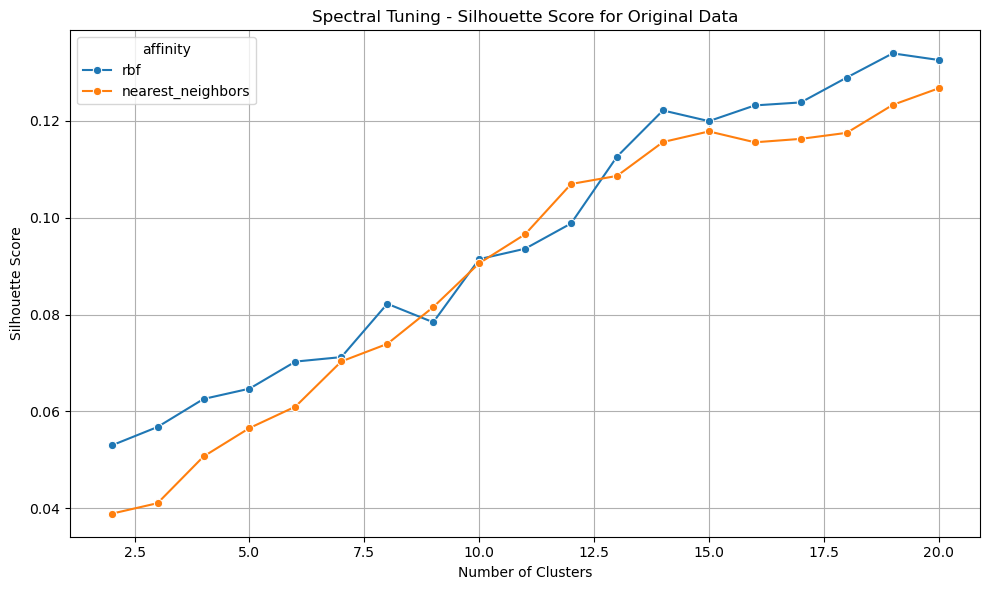

In [122]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for Original Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
best_labels, best_params, result_df = tune_spectral_clustering(reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.1404
n_clusters=3, affinity=rbf, silhouette_score=0.1619
n_clusters=4, affinity=rbf, silhouette_score=0.1715
n_clusters=5, affinity=rbf, silhouette_score=0.1868
n_clusters=6, affinity=rbf, silhouette_score=0.1944
n_clusters=7, affinity=rbf, silhouette_score=0.2144
n_clusters=8, affinity=rbf, silhouette_score=0.2344
n_clusters=9, affinity=rbf, silhouette_score=0.2462
n_clusters=10, affinity=rbf, silhouette_score=0.2631
n_clusters=11, affinity=rbf, silhouette_score=0.2776
n_clusters=12, affinity=rbf, silhouette_score=0.2698
n_clusters=13, affinity=rbf, silhouette_score=0.2780
n_clusters=14, affinity=rbf, silhouette_score=0.2441
n_clusters=15, affinity=rbf, silhouette_score=0.2401
n_clusters=16, affinity=rbf, silhouette_score=0.2462
n_clusters=17, affinity=rbf, silhouette_score=0.2350
n_clusters=18, affinity=rbf, silhouette_score=0.2585
n_clusters=19, affinity=rbf, silhouette_score=0.2383
n_clusters=20, affinity=rbf, silhouette_score=0.2336
n

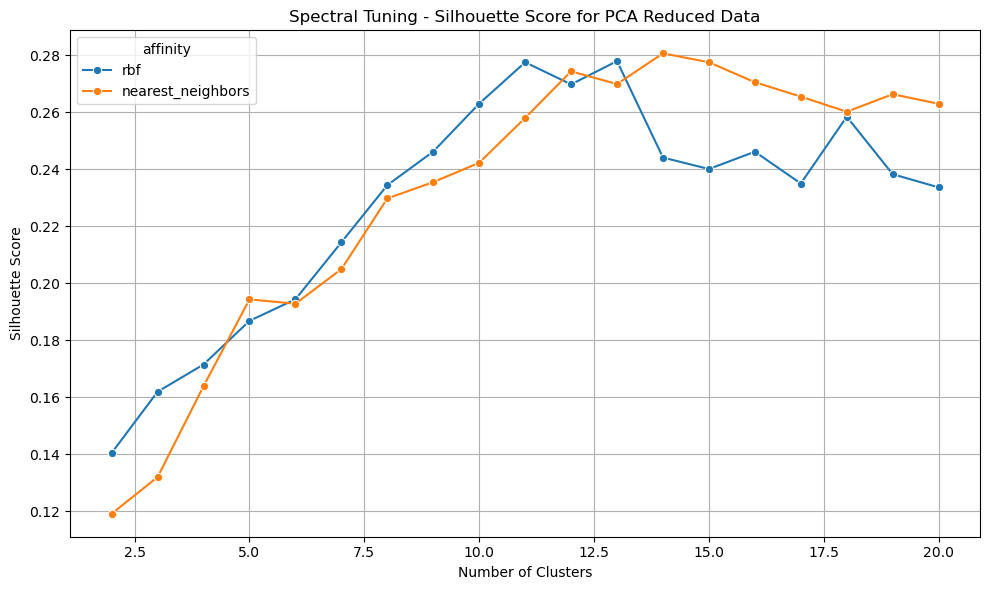

In [124]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
labels, best_params, result_df = tune_spectral_clustering(umap_reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.3542
n_clusters=3, affinity=rbf, silhouette_score=0.3078
n_clusters=4, affinity=rbf, silhouette_score=0.4042
n_clusters=5, affinity=rbf, silhouette_score=0.3995
n_clusters=6, affinity=rbf, silhouette_score=0.4409
n_clusters=7, affinity=rbf, silhouette_score=0.4474
n_clusters=8, affinity=rbf, silhouette_score=0.4689
n_clusters=9, affinity=rbf, silhouette_score=0.4250
n_clusters=10, affinity=rbf, silhouette_score=0.5185
n_clusters=11, affinity=rbf, silhouette_score=0.5320
n_clusters=12, affinity=rbf, silhouette_score=0.4997
n_clusters=13, affinity=rbf, silhouette_score=0.5170
n_clusters=14, affinity=rbf, silhouette_score=0.5440
n_clusters=15, affinity=rbf, silhouette_score=0.5456
n_clusters=16, affinity=rbf, silhouette_score=0.5213
n_clusters=17, affinity=rbf, silhouette_score=0.5111
n_clusters=18, affinity=rbf, silhouette_score=0.5237
n_clusters=19, affinity=rbf, silhouette_score=0.5349
n_clusters=20, affinity=rbf, silhouette_score=0.5236
n

c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=6, affinity=nearest_neighbors, silhouette_score=0.4140
n_clusters=7, affinity=nearest_neighbors, silhouette_score=0.4319
n_clusters=8, affinity=nearest_neighbors, silhouette_score=0.4412
n_clusters=9, affinity=nearest_neighbors, silhouette_score=0.4408
n_clusters=10, affinity=nearest_neighbors, silhouette_score=0.4984


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=11, affinity=nearest_neighbors, silhouette_score=0.5098
n_clusters=12, affinity=nearest_neighbors, silhouette_score=0.4979
n_clusters=13, affinity=nearest_neighbors, silhouette_score=0.4924
n_clusters=14, affinity=nearest_neighbors, silhouette_score=0.4801
n_clusters=15, affinity=nearest_neighbors, silhouette_score=0.5026


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=16, affinity=nearest_neighbors, silhouette_score=0.5198
n_clusters=17, affinity=nearest_neighbors, silhouette_score=0.5229
n_clusters=18, affinity=nearest_neighbors, silhouette_score=0.5015
n_clusters=19, affinity=nearest_neighbors, silhouette_score=0.5189
n_clusters=20, affinity=nearest_neighbors, silhouette_score=0.5306

✅ Best Params: n_clusters=15, affinity=rbf, silhouette_score=0.5456


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


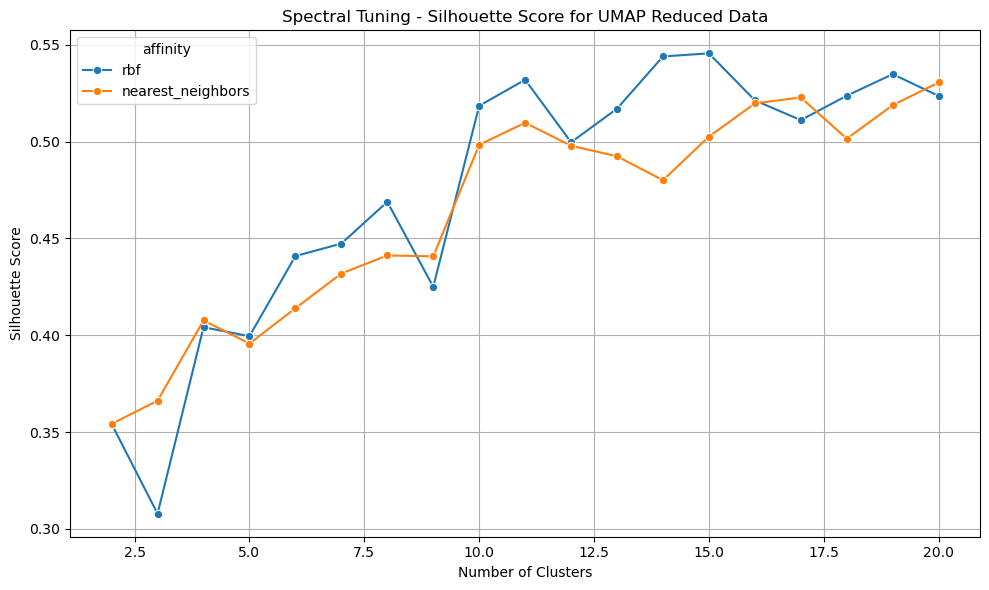

In [126]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
description_df['Spectral-Cluster'] = labels

In [128]:
df = df.merge(
    description_df[['Description', 'Spectral-Cluster']],
    left_on='Description',
    right_on='Description',
    how='left'
)

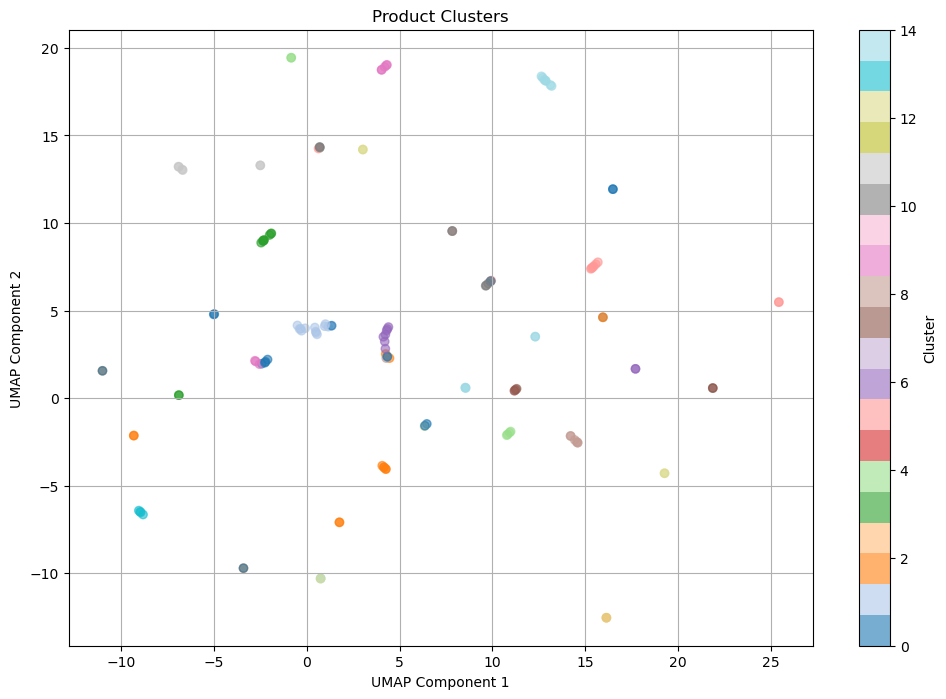

In [129]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['Spectral-Cluster'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

In [130]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'Spectral-Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['Spectral-Cluster'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['Spectral-Cluster'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [132]:
clusters = df.groupby('Spectral-Cluster')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- 6 ribbons rustic charm
- antique silver tea glass etched
- blue happy birthday bunting
- box of 24 cocktail parasols
- edwardian parasol natural
- fancy font birthday card
- mini cake stand hanging strawbery
- party bunting
- regency cakestand 3 tier
- set of 72 pink heart paper doilies
- tea party birthday card
- vintage heads and tails card game
- vintage snap cards
- vintage union jack bunting
- wooden happy birthday garland
- world war 2 gliders asstd designs

Cluster 1:
- assorted colour bird ornament
- colour glass tlight holder hanging
- four hook white lovebirds
- hanging heart zinc tlight holder
- hanging jam jar tlight holder
- hanging metal star lantern
- ivory hanging decoration heart
- love building block word
- lovebird hanging decoration white
- red toadstool led night light
- victorian glass hanging tlight
- white hanging heart tlight holder
- zinc metal heart decoration

Cluster 2:
- baking set 9 piece retrospot
- lunchbox with cutlery retrospot
- memo boa

# Save clusters

In [133]:
df.to_csv("../dataset/clustered_data.csv", index=False)

In [134]:
description_df.to_csv("../dataset/description_clusters.csv", index=False)